In [ ]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# ── Directories ───────────────────────────────
QUERY_DIR = Path("Data/Queries")
PLOT_DIR = Path("Plots")
PLOT_DIR.mkdir(parents=True, exist_ok=True)
quartiles = [0.25, 0.5, 0.75, 1.0]

# ── Loop over taxonomic levels ────────────────
for level in ["family", "genus", "species"]:
    dist_file = QUERY_DIR / f"{level}_distribution.csv"
    plot_file = PLOT_DIR / f"{level}_cumulative.png"

    df = pl.read_csv(dist_file).sort("observed")
    df = df.with_columns(pl.cum_sum("observed").alias("cumulative_observed"))
    df = df.with_row_index("rank", offset=1)

    # Quartile 
    total_obs = df["cumulative_observed"][-1]
    quartile_thresholds = [total_obs * q for q in quartiles]
    quartile_counts = []
    prev_idx = 0
    for q_val in quartile_thresholds:
        idx = int(np.searchsorted(df["cumulative_observed"].to_numpy(), q_val))
        quartile_counts.append(idx - prev_idx)
        prev_idx = idx
        
    print(f" 0–25% : {quartile_counts[0]} {level}")
    print(f" 25–50% : {quartile_counts[1]} {level}")
    print(f" 50–75% : {quartile_counts[2]} {level}")
    print(f" 75–100%: {quartile_counts[3]} {level}")

    # Plot 
    plt.figure(figsize=(10, 6))
    plt.plot(df["rank"], df["cumulative_observed"], linewidth=2)
    plt.title(f"Cumulative {level.capitalize()} Observations by Index", fontsize=14)
    plt.xlabel(f"{level.capitalize()} (rank order)", fontsize=12)
    plt.ylabel("Cumulative Observations", fontsize=12)

    # mark quartile 
    for q, val in zip(quartiles, quartile_thresholds):
        plt.axhline(y=val, color="gray", linestyle="--", alpha=0.4)
        plt.text(df["rank"][-1] * 0.98, val, f"{int(q*100)}%", va="center",
                 ha="right", fontsize=9, color="gray")

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(plot_file, dpi=300)
    plt.close()

    print(f"✅ Plot saved → {plot_file}")


In [ ]:
import polars as pl
from pathlib import Path
import numpy as np

# ── Directories ───────────────────────────────
QUERY_DIR = Path("Data/Queries")

# ── Process all distribution CSVs ─────────────
for level in ["family", "genus", "species"]:
    dist_file = QUERY_DIR / f"{level}_distribution.csv"
    out_file = QUERY_DIR / f"{level}_distribution_quartiled.csv"

    # Load data (sorted by observed)
    df = pl.read_csv(dist_file).sort("observed")

    # Compute cumulative and proportion of total
    df = df.with_columns([
        pl.cum_sum("observed").alias("cumulative_observed")
    ])
    total_obs = df["cumulative_observed"][-1]
    df = df.with_columns([
        (pl.col("cumulative_observed") / total_obs).alias("cum_fraction")
    ])

    # Assign quartiles based on cumulative fraction
    def assign_quartile(x):
        if x < 0.25:
            return 1
        elif x < 0.5:
            return 2
        elif x < 0.75:
            return 3
        else:
            return 4

    quartiles = [assign_quartile(x) for x in df["cum_fraction"].to_list()]

    # Add quartile column
    df = df.with_columns(pl.Series("quartile", quartiles, dtype=pl.Int8))

    # Save to new CSV
    df.write_csv(out_file)

    print(f"✅ {level.capitalize()} quartiles assigned → {out_file}")


In [ ]:
import polars as pl
from pathlib import Path

# ─── Directories ───────────────────────────────────────
MASTER_CSV = Path("Data/CSV/master.csv")
QUERY_DIR = Path("Data/Queries")
QUERY_DIR.mkdir(parents=True, exist_ok=True)

# ─── Load master dataset ────────────────────────────────
df = pl.read_csv(MASTER_CSV)

# ─── Function to generate observation + distribution files ─
for level in ["family", "genus", "species"]:
    counts = (
        df.group_by(level)
          .len()
          .rename({"len": "observed"})
    )

    # Sorted by ID (observation ordering)
    counts.sort(level).write_csv(QUERY_DIR / f"{level}_observation.csv")

    # Sorted by frequency (distribution ordering)
    counts.sort("observed").write_csv(QUERY_DIR / f"{level}_distribution.csv")

    print(f"✅ Saved → {QUERY_DIR / f'{level}_observation.csv'}")
    print(f"✅ Saved → {QUERY_DIR / f'{level}_distribution.csv'}")


pi/hist


In [ ]:
# pie_and_bins.py
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

# ---- config ----
DATA_PATH = Path("master.parquet")  # parquet or csv; change as needed
FAMILY_COL = "family"               # integer 1..60

# ---- load ----
if DATA_PATH.suffix.lower() == ".parquet":
    df = pl.read_parquet(DATA_PATH, use_statistics=False)
else:
    df = pl.read_csv(DATA_PATH)

# keep only 1..60
df = df.filter((pl.col(FAMILY_COL) >= 1) & (pl.col(FAMILY_COL) <= 60))

# ---- binning ----
# segment: 0=>1-20, 1=>21-40, 2=>41-60
seg = ((pl.col(FAMILY_COL) - 1) // 20).alias("seg")
# sub-bin (4 per segment, width=5), 0..3
sub = (((pl.col(FAMILY_COL) - 1) % 20) // 5).alias("sub")

binned = (
    df.select(seg, sub)
      .group_by(["seg", "sub"])
      .agg(pl.len().alias("n"))
)

# total per seg
seg_tot = binned.group_by("seg").agg(pl.col("n").sum().alias("N")).sort("seg")
N_total = int(seg_tot["N"].sum())

# ratios for pie (three wedges)
overall_ratios = (seg_tot["N"] / N_total).to_list()  # [r0, r1, r2]
pie_labels = ["Families 1–20", "Families 21–40", "Families 41–60"]
explode = [0.08, 0.08, 0.08]

# sub-bin ratios per seg (stacked bar parts): shape (3 segs, 4 sub-bins)
# fill zeros for missing combos
full = (
    pl.DataFrame(
        {"seg": np.repeat([0,1,2], 4), "sub": np.tile([0,1,2,3], 3)}
    ).join(binned, on=["seg", "sub"], how="left")
     .fill_null(0)
     .join(seg_tot, on="seg", how="left")
     .with_columns((pl.col("n") / N_total).alias("r_part"))
     .sort(["seg", "sub"])
)

# reshape to list-of-lists for stacking
parts = [full.filter(pl.col("seg")==s)["r_part"].to_list() for s in (0,1,2)]

# ---- plotting ----
fig, (ax_pie, ax_bar) = plt.subplots(1, 2, figsize=(10.5, 5.5))
fig.subplots_adjust(wspace=0.05)

# pie
angle = -180 * overall_ratios[0]  # split first wedge across x-axis (style from template)
wedges, *_ = ax_pie.pie(
    overall_ratios,
    autopct='%1.1f%%',
    startangle=angle,
    labels=pie_labels,
    explode=explode
)
ax_pie.set_aspect('equal')

# stacked bars (one bar per segment; each bar sums to its pie ratio)
width = 0.25
xs = [-width*1.5, 0.0, width*1.5]  # positions for seg 0,1,2
sub_labels = ["1–5","6–10","11–15","16–20"]  # reused per segment (relative)
colors = [f"C{i}" for i in range(4)]

bar_tops = []
for i, (x, stack) in enumerate(zip(xs, parts)):
    bottom = 0.0
    for j, h in enumerate(stack):
        bc = ax_bar.bar(x, h, width, bottom=bottom, label=sub_labels[j] if i==0 else None, alpha=0.35+0.15*j)
        # label inside each block
        if h > 0:
            ax_bar.bar_label(bc, labels=[f"{(h/N_total)*100*N_total:.1f}%"], label_type='center', padding=0)
        bottom += h
    bar_tops.append(bottom)

ax_bar.set_xlim(min(xs)-width*2.0, max(xs)+width*2.0)
ax_bar.set_ylim(0, max(bar_tops)*1.05 if bar_tops else 1)
ax_bar.set_title("Within-segment distributions (5-wide bins)")
ax_bar.set_xticks(xs, ["1–20", "21–40", "41–60"])
ax_bar.legend(title="Sub-bins", loc="upper right", frameon=False)
ax_bar.axis('off')  # mirror the template’s clean look

# ---- connect wedges to bars ----
# helper to attach two lines per wedge (top and bottom of its bar)
def connect_wedge_to_bar(wedge, x, bar_height, axA=ax_bar, axB=ax_pie, lw=3.0):
    theta1, theta2 = wedge.theta1, wedge.theta2
    center, r = wedge.center, wedge.r

    # top line
    xt = x - width/2
    yt = bar_height
    xw_top = r * np.cos(np.deg2rad(theta2)) + center[0]
    yw_top = r * np.sin(np.deg2rad(theta2)) + center[1]
    con = ConnectionPatch(xyA=(xt, yt), coordsA=axA.transData,
                          xyB=(xw_top, yw_top), coordsB=axB.transData)
    con.set_color([0, 0, 0]); con.set_linewidth(lw)
    axA.add_artist(con)

    # bottom line
    xb = x - width/2
    yb = 0.0
    xw_bot = r * np.cos(np.deg2rad(theta1)) + center[0]
    yw_bot = r * np.sin(np.deg2rad(theta1)) + center[1]
    con2 = ConnectionPatch(xyA=(xb, yb), coordsA=axA.transData,
                           xyB=(xw_bot, yw_bot), coordsB=axB.transData)
    con2.set_color([0, 0, 0]); con2.set_linewidth(lw)
    axA.add_artist(con2)

# do connections for each (wedge i -> bar i)
for i in range(3):
    connect_wedge_to_bar(wedges[i], xs[i], bar_tops[i])

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier

from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier


In [ ]:
base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

models = {
    # ===== SVMs =====
    # Proper arg is `estimator` (not base_estimator). SVC already supports probas, but we keep calibration for better calibration.
    "SVC_RBF_cal": Pipeline([
        ("scale", StandardScaler()),
        ("clf", CalibratedClassifierCV(
            estimator=SVC(kernel="rbf", C=2.0, gamma="scale",
                          class_weight="balanced", probability=True, random_state=42),
            method="sigmoid", cv=3
        ))
    ]),
    # LinearSVC has no proba — wrap in OvR, then calibrate
    "LinearSVC_OvR_cal": Pipeline([
        ("scale", StandardScaler()),
        ("clf", CalibratedClassifierCV(
            estimator=OneVsRestClassifier(LinearSVC(C=1.0, class_weight="balanced", random_state=42)),
            method="sigmoid", cv=3
        ))
    ]),

    # ===== Bagging =====
    "BalancedRF": BalancedRandomForestClassifier(
        n_estimators=300, max_depth=None, n_jobs=-1, sampling_strategy="auto", random_state=42
    ),
    # EasyEnsemble defaults to AdaBoost+stumps internally; `base_estimator` is deprecated — just use defaults
    "EasyEnsemble": EasyEnsembleClassifier(
        n_estimators=20, random_state=42, n_jobs=-1
    ),
    # sklearn switched `base_estimator` -> `estimator`
    "Bagging_DT": BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=None, class_weight="balanced", random_state=42),
        n_estimators=300, max_samples=1.0, max_features=0.6, n_jobs=-1, random_state=42
    ),

    # ===== Boosting =====
    # Use SAMME for multiclass with stumps; supports sample_weight
    "AdaBoost_SAMME": AdaBoostClassifier(
        estimator=base_stump, n_estimators=500, learning_rate=0.5, algorithm="SAMME", random_state=42
    ),
    # RUSBoost uses `estimator` (not base_estimator)
    "RUSBoost": RUSBoostClassifier(
        estimator=base_stump, n_estimators=500, learning_rate=0.5, random_state=42
    ),
    # HGBT: no class_weight; DO pass sample_weight at fit time if you’ve built one
    "HGBT": HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.1, max_iter=300, l2_regularization=0.0, random_state=42
    ),
}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_SEED)

def rar_weight_vector(y_true):
    w = np.array([class_weight[yy] for yy in y_true], float)
    return w / w.mean()

def customs_score(y_true, y_pred):
    # rarity-weighted macro recall (you can swap for macro-F1)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    with np.errstate(divide="ignore", invalid="ignore"):
        recall_c = np.diag(cm) / cm.sum(axis=1).clip(min=1)
    w = np.array([class_weight[c] for c in classes])
    w /= w.sum()
    return np.nan_to_num((w * recall_c).sum())

def macro_auc_ovr(y_true, prob, classes):
    # y_true integer in [0..K-1] or class labels present in `classes`
    y_bin = label_binarize(y_true, classes=classes)
    if prob.shape[1] != len(classes):
        # align columns
        raise ValueError("Probability shape != n_classes")
    try:
        return roc_auc_score(y_bin, prob, average="macro", multi_class="ovr")
    except Exception:
        return np.nan


In [ ]:
row_metrics = []   # per-fold
agg_results = []   # per-model summary

# choose a baseline for t-tests (BalancedRF is a good reference)
baseline_key = "BalancedRF"
per_fold_scores = {key: [] for key in models}

for key, clf in models.items():
    fold_idx = 0
    # Probabilities needed for ROC; if model lacks proba, skip AUC
    need_proba = True

    y_preds, y_probas, y_trues = [], [], []

    for tr, te in cv.split(X, y):
        Xtr, Xte = X[tr], X[te]
        ytr, yte = y[tr], y[te]

        # fit with sample weights when supported
        supports_sw = hasattr(clf, "fit") and "sample_weight" in clf.fit.__code__.co_varnames
        if key in {"AdaBoost_SAMME", "HGBT"} and supports_sw:
            clf.fit(Xtr, ytr, **({"sample_weight": sample_weight[tr]}))
        else:
            clf.fit(Xtr, ytr)

        yp = clf.predict(Xte)
        y_preds.append(yp)
        y_trues.append(yte)

        if hasattr(clf, "predict_proba"):
            try:
                proba = clf.predict_proba(Xte)
                y_probas.append(proba)
            except Exception:
                need_proba = False
        else:
            need_proba = False

        # per-fold Customs score for later t-tests
        per_fold_scores[key].append(customs_score(yte, yp))
        fold_idx += 1

    y_true_all = np.concatenate(y_trues)
    y_pred_all = np.concatenate(y_preds)
    acc = (y_true_all == y_pred_all).mean()
    f1_macro = f1_score(y_true_all, y_pred_all, average="macro")
    bacc = balanced_accuracy_score(y_true_all, y_pred_all)
    cscore = customs_score(y_true_all, y_pred_all)

    auc_macro = np.nan
    if need_proba and len(y_probas):
        y_proba_all = np.vstack(y_probas)
        auc_macro = macro_auc_ovr(y_true_all, y_proba_all, classes)

    agg_results.append((key, acc, f1_macro, bacc, auc_macro, cscore))

    row_metrics.append({
        "model": key,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "balanced_acc": bacc,
        "macro_auc_ovr": auc_macro,
        "customs_score": cscore
    })

# summary table
summary = pd.DataFrame(agg_results, columns=["model","accuracy","f1_macro","balanced_acc","macro_auc_ovr","customs_score"])
summary = summary.sort_values("customs_score", ascending=False)
print("\n== Summary (sorted by Customs score) ==\n")
print(summary)

# ---------- paired t-tests (Customs score per fold) ----------
print("\n== Paired t-tests vs baseline ({}) on Customs score ==".format(baseline_key))
base_vec = np.array(per_fold_scores[baseline_key], float)
for key in models:
    if key == baseline_key: 
        continue
    vec = np.array(per_fold_scores[key], float)
    if len(vec) == len(base_vec):
        t, p = ttest_rel(vec, base_vec, nan_policy="omit")
        print(f"{key:20s}  t={t: .3f}  p={p: .4f}")

# ---------- choose best, fit on ALL data, save ----------
best_key = summary.iloc[0]["model"]
best_model = models[best_key]

supports_sw = hasattr(best_model, "fit") and "sample_weight" in best_model.fit.__code__.co_varnames
if best_key in {"AdaBoost_SAMME", "HGBT"} and supports_sw:
    best_model.fit(X, y, **({"sample_weight": sample_weight}))
else:
    best_model.fit(X, y)

Path("models").mkdir(exist_ok=True, parents=True)
joblib.dump({"pipeline": best_model, "classes": classes}, "models/best_model.joblib")
print(f"\nSaved best model: {best_key} -> models/best_model.joblib")

# ---------- quick confusion matrix + report (aggregate) ----------
yp_all = cross_val_predict(best_model, X, y, cv=cv)
print("\n== Confusion Matrix (aggregate across CV) ==")
print(confusion_matrix(y, yp_all, labels=classes))
print("\n== Classification Report (macro-averaged) ==")
print(classification_report(y, yp_all, digits=3))

# ---------- API for the notebook end ----------
def load_best_model(path="models/best_model.joblib"):
    bundle = joblib.load(path)
    return bundle["pipeline"], bundle["classes"]

def predict_new(X_new, model_path="models/best_model.joblib", top_k=3):
    pipe, cls = load_best_model(model_path)
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_new)
        top_idx = np.argsort(-proba, axis=1)[:, :top_k]
        top_labels = np.array(cls)[top_idx]
        top_scores = np.take_along_axis(proba, top_idx, axis=1)
        return top_labels, top_scores
    else:
        # fallback: decision function → softmax-like ranking
        pred = pipe.predict(X_new)
        return pred, None

In [ ]:
# Parameters
n_estimators = 50
plot_step = 0.02  
plot_step_coarser = 0.5 
RANDOM_SEED = rdm_state  

data = pd.read_parquet(DATA_CLEAN)
X = data.drop(["species"], axis=1)
y = data["species"]
print(len(X.columns))
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=0
)

225


In [ ]:
classifier1 = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=RANDOM_SEED),
    n_estimators=n_estimators,
    random_state=RANDOM_SEED
)
classifier1.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=1234),
                   random_state=1234)

In [ ]:
classes = classifier1.classes_
y_bin = label_binarize(y_test, classes=classes)
proba = classifier1.predict_proba(X_test)

per_class_auc = {}
present_mask = []

for i, c in enumerate(classes):
    yt = y_bin[:, i]
    # need at least one positive and one negative
    if yt.max() == yt.min():
        per_class_auc[int(c)] = math.nan  # undefined; class absent or all one label
        present_mask.append(False)
        continue
    per_class_auc[int(c)] = roc_auc_score(yt, proba[:, i])
    present_mask.append(True)

# weighted overall over classes that are actually present
present_mask = np.array(present_mask, dtype=bool)
if present_mask.any():
    # weights by class prevalence in y_test
    weights = y_bin[:, present_mask].sum(axis=0)
    weights = weights / weights.sum()
    auc_vals = np.array([per_class_auc[int(c)] for c in classes[present_mask]])
    auc_overall = float(np.average(auc_vals, weights=weights))
else:
    auc_overall = math.nan

print(f"AUC (weighted OVR over present classes): {auc_overall:.6f}")
print("Per-class AUC (NaN = undefined):", {k: (None if np.isnan(v) else round(v, 6))
                                           for k, v in per_class_auc.items()})

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_ranking

In [ ]:
pipe.fit(ins1, outs1)

Pipeline(steps=[('scale', StandardScaler()), ('under', RandomUnderSampler()),
                ('model',
                 AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                                     max_leaf_nodes=3),
                                    learning_rate=0.5, n_estimators=500,
                                    random_state=42))])

In [ ]:
classes = np.unique(outs0)
y_bin = label_binarize(outs0, classes=classes)
auc_macro = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")

In [ ]:
print(classification_report(outs0, preda))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00        20
           6       0.00      0.00      0.00        19
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00        19
          12       0.00      0.00      0.00        29
          13       0.00      0.00      0.00        10
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00        38
          16       0.00      1.00      0.00        25
          17       0.00      0.00      0.00        26
          18       0.00    

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [ ]:
conf = confusion_matrix(outs0, preda)

In [ ]:
fpr, tpr, _ = roc_curve(outs0, proba)
auc_score = roc_auc_score(outs0, proba)

ValueError: multiclass format is not supported

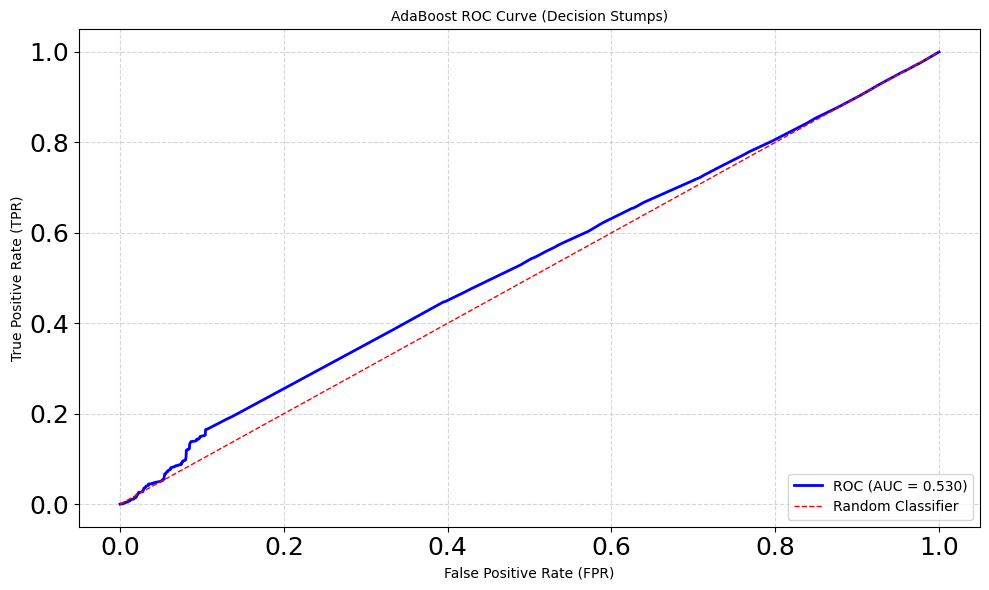

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', lw=1, label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=FONTSIZE)
plt.ylabel('True Positive Rate (TPR)', fontsize=FONTSIZE)
plt.title("AdaBoosted Decision Trees ROC Curve", fontsize=FONTSIZE)
plt.legend(loc='lower right', fontsize=FONTSIZE)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

In [ ]:
x = np.arange(len(tpr)) 

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(x, tpr, 'g-o', label='TPR (True Positive Rate)')
plt.plot(x, fpr, 'r-o', label='FPR (False Positive Rate)')
plt.title('TPR and FPR Across Boosting Stages', fontsize=FONTSIZE)
plt.xlabel('n_estimators', fontsize=FONTSIZE)
plt.ylabel('Rate', fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Model 2: Gradient Boosted Decision Trees

In [ ]:
from sklearn.ensemble import (GradientBoostingClassifier)

In [ ]:
data = pd.read_parquet("Data/master_feats.parquet") 

In [ ]:
xgb_wood_classif = xgb.XGBClassifier(n_jobs=10)
xgb_wood_classif.fit(X_train,y_train)

In [ ]:
X = data.iloc[:, 3:].to_numpy()
y_raw = data.iloc[:, 2].to_numpy()
le = LabelEncoder()
y = le.fit_transform(y_raw).astype(np.int64)  

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=rdm_state,
)

In [ ]:
base_gb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y)),
    learning_rate=0.05,
    n_estimators=150,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=rdm_state
)

In [ ]:
bagging_gb = BalancedBaggingClassifier(
    estimator=base_gb,
    n_estimators=10,
    sampling_strategy='auto',  # balance classes on each bag
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1,
    random_state=rdm_state
)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=3,
    random_state=rdm_state
)

In [ ]:
ensemble = VotingClassifier(
    estimators=[('bagging_gb', bagging_gb), ('random_forest', rf)],
    voting='soft'
)

In [ ]:
ensemble.fit(X_train, y_train)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229], got [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231]

# Model 3 & 4: Classifying Genus

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[3:]].values, df[0].values, random_state=1, test_size=0.2)
## create different RF varying N and DT_depth
RF_N = []
RF_DTdepth = []
RF_Acc = []
for a in np.array([3, 5, 11, 21, 33, 51,101]):#([50, 75, 100, 125, 150]):
    for b in np.array([1,4,10,25,50,75,100,150,200]):
    #for b in np.array([150]):
        print('N =',a,'DT_depth =',b)
        N=a
        DT_depth=b
        ##########################################################################
        rf = RandomForestClassifier(n_estimators=N, max_depth=DT_depth)
        classifier = rf.fit(X_train, y_train)
        #print(classifier.score(X_test, y_test))
        Accuracy = classifier.score(X_test, y_test)
        print('Accuracy =',Accuracy)
        RF_N.append(N)
        RF_DTdepth.append(DT_depth)
        RF_Acc.append(Accuracy)
# Create a dataframe to plot
RF_Performance_df = {'N': RF_N,
        'DT_depth': RF_DTdepth,
        'Accuracy': RF_Acc}
RF_Performance_df = pd.DataFrame(RF_Performance_df)
print(RF_Performance_df)

In [ ]:
# TEMPORARY CELL 
# to hold the results to plot below
temp = RF_Performance_df.copy()
new_row = {'N':3, 'DT_depth':'NA', 'Accuracy':0.97}
#temp = temp.append(new_row, ignore_index=True)
print(temp)

In [ ]:
figRFPerf, axRFPerf = plt.subplots(figsize=(8, 5), layout='constrained')
for x in RF_Performance_df['DT_depth'].unique():
    test = axRFPerf.plot('N','Accuracy', data=RF_Performance_df.loc[RF_Performance_df['DT_depth']==x,:], label=x, linewidth=1)
    #axRFPerf.scatter('N','Accuracy', data=RF_Performance_df.loc[RF_Performance_df['DT_depth']==x,:], label=x)
    #axRFPerf.plot('N','Accuracy','r.', data=RF_Performance_df.loc[RF_Performance_df['DT_depth']==x,:], label=x, linewidth=1)
axRFPerf.set_xlabel('N', fontsize='15')
axRFPerf.set_ylabel('Accuracy', fontsize='15')
#axRFPerf.xticks(fontsize='15')
#axRFPerf.yticks(fontsize='15')
axRFPerf.set_xlim(0,70)
plt.title("RF with Tchebichev moments", fontsize='15')
plt.legend(title='DT_depth', title_fontsize='15', loc='upper right',fontsize="12")
#plt.legend((test, test),('SDF','asad'), title='DT_depth', loc='upper right',fontsize="15")
#figRFPerf.savefig("Tchebichev_RF_scikit_N_DTdepth_plot.pdf")
plt.show()

In [ ]:
figRFPerf, axRFPerf = plt.subplots(figsize=(8, 5), layout='constrained')
for x in RF_Performance_df['N'].unique():
    axRFPerf.plot('DT_depth','Accuracy', data=RF_Performance_df.loc[RF_Performance_df['N']==x,:], label=x,linewidth=1)
    #axRFPerf.scatter('DT_depth','Accuracy', data=RF_Performance_df.loc[RF_Performance_df['N']==x,:], label=x)
axRFPerf.set_xlabel('DT_depth', fontsize='15')
axRFPerf.set_ylabel('Accuracy', fontsize='15')
axRFPerf.set_xlim(0,250)
plt.title("RF with Tchebichev moments", fontsize='15')
plt.legend(title='N', title_fontsize='15', loc='upper right',fontsize="15")
#figRFPerf.savefig("Tchebichev_RF_scikit_N_DTdepth_plot2.pdf")
plt.show()

In [ ]:
train_metrics = classifier2.score(xin, yout)
print('XGBClassifier accuracy training: ' , train_metrics)

NotFittedError: need to call fit or load_model beforehand

In [ ]:
test_metrics = classifier2.score(xtest, ytest)
print('XGBClassifier accuracy test: ' , test_metrics)

XGBClassifier accuracy test:  0.10665168845315905


In [ ]:
proba = pipe.predict_proba(xtest)
classes = np.unique(yout)
n_classes = len(classes)
y_bin = label_binarize(ytest, classes=classes)


In [ ]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("under", RandomUnderSampler(sampling_strategy="auto", random_state=rdm_state)),
    ("model", XGBClassifier(
        learning_rate=lr,
        n_estimators=n_estimators,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective="multi:softprob",
        eval_metric="mlogloss",
        random_state=rdm_state,
        n_jobs=-1,
        verbosity=0
    ))
])

In [ ]:
fpr, tpr, roc_auc = {}, {}, {}

In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr  /= n_classes
macro_auc  = auc(all_fpr, mean_tpr)
print(f"Macro-average AUC: {macro_auc:.4f}")



In [ ]:
FIGSIZE = (10,6)

In [ ]:
plt.figure(figsize=FIGSIZE)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Per-Class ROC Curves")
plt.legend()

In [ ]:
plt.figure(figsize=FIGSIZE)
tpr_vals = [np.mean(tpr[i]) for i in range(n_classes)]
fpr_vals = [np.mean(fpr[i]) for i in range(n_classes)]
diff_vals = np.array(tpr_vals) - np.array(fpr_vals)
plt.plot(classes, tpr_vals, marker='o', label="TPR")
plt.plot(classes, fpr_vals, marker='s', label="FPR")
plt.plot(classes, diff_vals, marker='^', label="TPR − FPR")
plt.xlabel("Class")
plt.ylabel("Rate")
plt.legend()


In [ ]:
in1, in0, out1, out0 = train_test_split(
    ins,
    outs,
    test_size = 0.2,
    stratify = outs,
    random_state = rdm_state
)

In [ ]:
max_n = 100

In [ ]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=max_n,
    random_state=rdm_state
)
ada.fit(in1, out1)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100, random_state=1234)

In [ ]:
proba = ada.predict_proba(in0)

In [ ]:
n_classes = len(np.unique(out0))
in0_bin = label_binarize(out0, classes=np.arange(n_classes))

In [ ]:
fpr, tpr, _ = roc_curve(in0_bin.ravel(), proba.ravel())
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', lw=1, label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)', fontsize=FONTSIZE)
plt.ylabel('True Positive Rate (TPR)', fontsize=FONTSIZE)
plt.title("AdaBoosted Decision Trees ROC Curve", fontsize=FONTSIZE)
plt.legend(loc='lower right', fontsize=FONTSIZE)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

In [ ]:
x = np.arange(len(tpr)) 

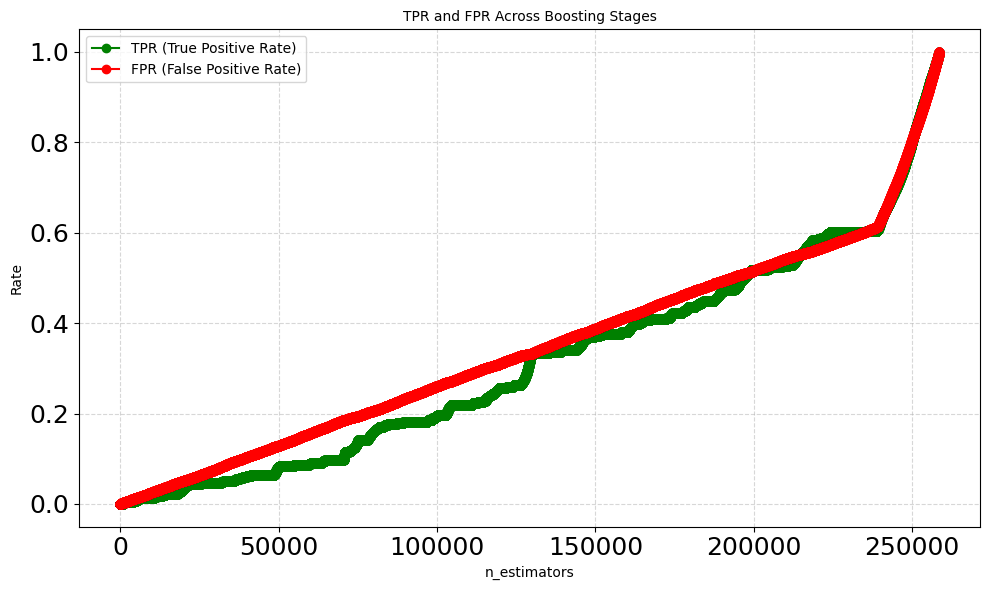

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(x, tpr, 'g-o', label='TPR (True Positive Rate)')
plt.plot(x, fpr, 'r-o', label='FPR (False Positive Rate)')
plt.title('TPR and FPR Across Boosting Stages', fontsize=FONTSIZE)
plt.xlabel('n_estimators', fontsize=FONTSIZE)
plt.ylabel('Rate', fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Model 1 Takeaways

AdaBoosted Decision trees actually performed better on the species data (1/927) then the families data (1/60). Could see further improvement with increased classifiers but with the small AUC in the first place (without rigorous feature selection), it is my advice to pursue alternate methods.

In [ ]:
gc.collect()

14223

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB 

import joblib

import pickle as pkl

##############
FIGSIZE = (10,6)
FONTSIZE = 10

rdm_state = 1234

DATA_CLEAN = Path("Data/master_clean.parquet")

plt.rcParams["figure.figsize"] = FIGSIZE
plt.rcParams["font.size"] = FONTSIZE
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs 
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribs].values   

In [ ]:
def plot_probs(outs, proba):
    pred = proba[:,0] >= 0.5
    confusion = confusion_matrix(outs,pred)
    print("Confusion", confusion)
    
    print("Log loss", log_loss(outs, proba))
    
    fpr, tpr, thresholds = roc_curve(outs, proba[:, 0])
    fig, ax = plt.subplots(figsize = FIGSIZE)
    ax.plot(thresholds ,tpr, color = "b")
    ax.plot(thresholds ,fpr, color = "r")
    ax.plot(thresholds ,tpr-fpr, color = "g")
    ax.set_xlabel("threshold", fontsize = FONTSIZE)
    ax.set_ylabel("fraction", fontsize = FONTSIZE)
    ax.legend(["TPR", "FPR", "Distance"], fontsize = FONTSIZE)
    
    # ROC
    fig, ax = plt.subplots(figsize=FIGSIZE)
    ax.plot(fpr, tpr, color = "b")
    ax.plot([0,1], [0,1], "r--")
    ax.set_xlabel("FPR", fontsize=FONTSIZE)
    ax.set_ylabel("TPR", fontsize=FONTSIZE)
    ax.set_aspect("equal", "box")
    print("AUC", auc(fpr,tpr))
    
def plot_species(species_modified, outs, proba):
    plt.figure(figsize=FIGSIZE)
    plt.plot(species_modified, proba[:,0], "r")
    plt.plot(species_modified, proba[:,1], "g")
    plt.plot(species_modified, outs*0.1-0.2, "k")
    plt.set_xlabel("Species", fontsize=FONTSIZE)
    plt.set_ylabel("Probability", fontsize=FONTSIZE)
    
def plot_3d(ins, pred):
    fig = plt.figure(figsize=FIGSIZE)
    ax = fig.gca(projection = "3d")
    ax.plot_trisurf(ins[:,0], ins[:,1], pred, cmap = plt.cm.jet)
    
def scatter_plot(ins, pred=None, centers = None, cmap = plt.cm.brg):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    if pred is None:
        ax.plot(ins[:,0], ins[:,1], c = pred, s = 5, cmap = cmap)
    else:
        ax.scatter(ins[:,0], ins[:,1], c = pred, s = 5, cmap = cmap)
    if centers is not None:
        mn = np.min(pred)
        mx = np.max(pred)
        print(np.arange(mn, mx+1))
        ax.scatter(
            centers[:,0], 
            centers[:,1], 
            c = np.arange(mn, mx+1), 
            marker = "D",
            s = 100,
            cmap = cmap
        )

## 2.02 | Data Layout

In [ ]:
data = pd.read_parquet(DATA_CLEAN)

In [ ]:
classes = ["family", "genus", "species"]
features = [c for c in data.columns if c not in classes]

In [ ]:
label_info = {
    int(row['species']): (int(row['genus']), int(row['family']))
    for _, row in df[['family','genus','species']].drop_duplicates().iterrows()
}
# true_genus, true_family = label_info[true_species]
# pred_genus, pred_family = label_info[pred_species]

In [ ]:
ins = data[features]
outs = data["species"]

In [ ]:
in1, in0, out1, out0 = train_test_split(
    ins,
    outs,
    test_size = 0.2,
    stratify = outs,
    random_state = rdm_state
)

# Model 2 | Extreme Gradient Boosted Decision Trees

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    ins, outs, test_size=0.25, random_state=42, stratify=y
)

In [ ]:
xgb_base = xgb.XGBClassifier(
    objective='multi:softprob', 
    num_class=3,                 
    n_estimators=100,            
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,               
    colsample_bytree=0.8,        
    eval_metric='mlogloss',    
    use_label_encoder=False,
    random_state=42
)

In [ ]:
bagged_xgb = BaggingClassifier(
    estimator=xgb_base,
    n_estimators=10,  # Number of XGBoost models to build
    random_state=42,
    n_jobs=-1         # Use all available CPU cores
)

In [ ]:
print("Starting training of the bagged XGBoost ensemble...")
bagged_xgb.fit(X_train, y_train)
print("Training complete.")

In [ ]:
y_pred = bagged_xgb.predict(X_test)

In [ ]:
y_pred_proba = bagged_xgb.predict_proba(X_test)


In [ ]:
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

In [ ]:
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1", "Class 2"]))


In [ ]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Class 0", "Class 1", "Class 2"],
            yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Model 3 | Subagging XGBoost

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.feature_selection import VarianceThreshold, SelectFromModel

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB 

import joblib

import pickle as pkl

##############
FIGSIZE = (10,6)
FONTSIZE = 10

rdm_state = 1234

DATA_CLEAN = Path("Data/master_clean.parquet")

plt.rcParams["figure.figsize"] = FIGSIZE
plt.rcParams["font.size"] = FONTSIZE
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

In [ ]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribs = attribs 
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribs].values   

In [ ]:
# def plot_probs(outs, proba):
#     pred = proba[:,0] >= 0.5
#     confusion = confusion_matrix(outs,pred)
#     print("Confusion", confusion)
    
#     print("Log loss", log_loss(outs, proba))
    
#     fpr, tpr, thresholds = roc_curve(outs, proba[:, 0])
#     fig, ax = plt.subplots(figsize = FIGSIZE)
#     ax.plot(thresholds ,tpr, color = "b")
#     ax.plot(thresholds ,fpr, color = "r")
#     ax.plot(thresholds ,tpr-fpr, color = "g")
#     ax.set_xlabel("threshold", fontsize = FONTSIZE)
#     ax.set_ylabel("fraction", fontsize = FONTSIZE)
#     ax.legend(["TPR", "FPR", "Distance"], fontsize = FONTSIZE)
    
#     # ROC
#     fig, ax = plt.subplots(figsize=FIGSIZE)
#     ax.plot(fpr, tpr, color = "b")
#     ax.plot([0,1], [0,1], "r--")
#     ax.set_xlabel("FPR", fontsize=FONTSIZE)
#     ax.set_ylabel("TPR", fontsize=FONTSIZE)
#     ax.set_aspect("equal", "box")
#     print("AUC", auc(fpr,tpr))
    
# def plot_species(species_modified, outs, proba):
#     plt.figure(figsize=FIGSIZE)
#     plt.plot(species_modified, proba[:,0], "r")
#     plt.plot(species_modified, proba[:,1], "g")
#     plt.plot(species_modified, outs*0.1-0.2, "k")
#     plt.set_xlabel("Species", fontsize=FONTSIZE)
#     plt.set_ylabel("Probability", fontsize=FONTSIZE)
    
# def plot_3d(ins, pred):
#     fig = plt.figure(figsize=FIGSIZE)
#     ax = fig.gca(projection = "3d")
#     ax.plot_trisurf(ins[:,0], ins[:,1], pred, cmap = plt.cm.jet)
    
# def scatter_plot(ins, pred=None, centers = None, cmap = plt.cm.brg):
#     fig, ax = plt.subplots(figsize=FIGSIZE)
#     if pred is None:
#         ax.plot(ins[:,0], ins[:,1], c = pred, s = 5, cmap = cmap)
#     else:
#         ax.scatter(ins[:,0], ins[:,1], c = pred, s = 5, cmap = cmap)
#     if centers is not None:
#         mn = np.min(pred)
#         mx = np.max(pred)
#         print(np.arange(mn, mx+1))
#         ax.scatter(
#             centers[:,0], 
#             centers[:,1], 
#             c = np.arange(mn, mx+1), 
#             marker = "D",
#             s = 100,
#             cmap = cmap
#         )

## 2.01 | Model's Data Layout

In [ ]:
classes = ["family", "genus", "species"]
features = [c for c in data.columns if c not in classes]

In [ ]:
label_info = {
    int(row['species']): (int(row['genus']), int(row['family']))
    for _, row in df[['family','genus','species']].drop_duplicates().iterrows()
}
# true_genus, true_family = label_info[true_species]
# pred_genus, pred_family = label_info[pred_species]

In [ ]:
ins = data[features]
outs = data["species"]

In [ ]:
in1, in0, out1, out0 = train_test_split(
    ins,
    outs,
    test_size = 0.2,
    stratify = outs,
    random_state = rdm_state
)

In [ ]:
if len(n_points) == 1 and len(fpr) > 1:
    n_points = np.arange(len(fpr)) 

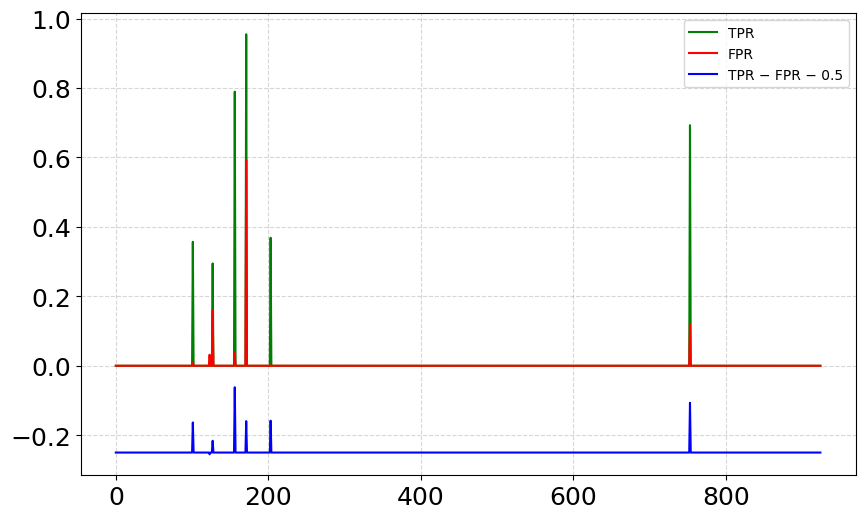

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(n_points, tpr, "g", label="TPR")
plt.plot(n_points, fpr, "r", label="FPR")
plt.plot(n_points, (tpr - fpr)*0.25-0.25, "b", label="TPR − FPR − 0.5")

plt.legend(fontsize=FONTSIZE)
plt.grid(True, linestyle="--", alpha=0.5)

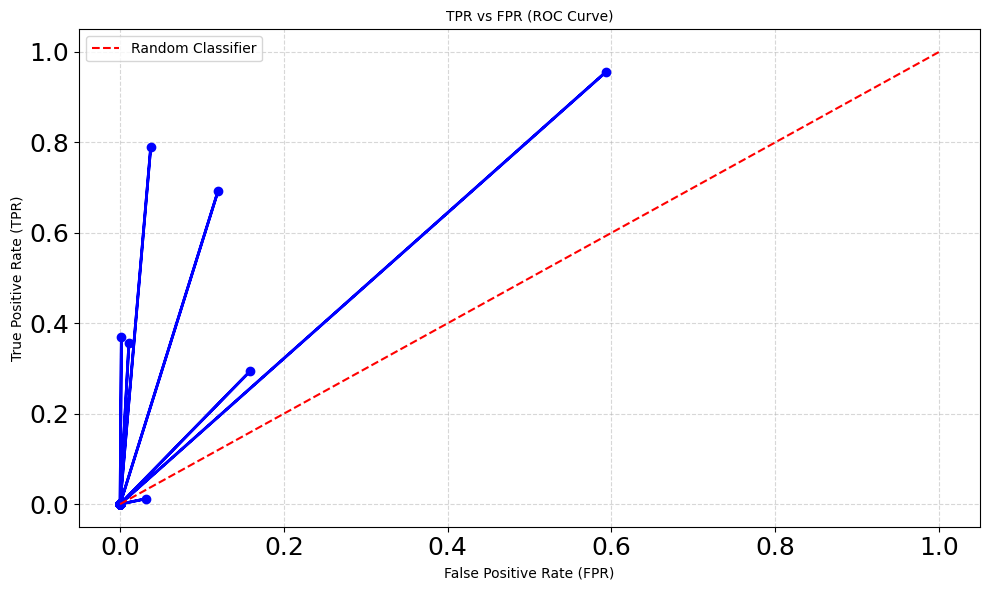

In [ ]:

plt.figure(figsize=FIGSIZE)
plt.plot(fpr, tpr, marker='o', color='b', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier')  
plt.title('TPR vs FPR (ROC Curve)', fontsize=FONTSIZE)
plt.xlabel('False Positive Rate (FPR)', fontsize=FONTSIZE)
plt.ylabel('True Positive Rate (TPR)', fontsize=FONTSIZE)
plt.legend(fontsize=FONTSIZE)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
for n in range(10, 51, 5):
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1), 
        n_estimators=n,
        random_state=rdm_state
    )
    ada.fit(in1, out1)
    preds = ada.predict(in0)
    fpr, tpr = compute_fpr_tpr(
        out0.values,
        preds,
        n_classes=outs.nunique()
    )
    avg_fpr.append(fpr)
    avg_tpr.append(tpr)

KeyboardInterrupt: 

In [ ]:
        ada.fit(in1, out1)
        preds = ada.predict(in0)
        fpr, tpr = compute_fpr_tpr(
            out0.values, 
            preds, 
            n_classes=outs.nunique()
        )
        avg_fpr.append(fpr)
        avg_tpr.append(tpr)

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(avg_fpr, avg_tpr, marker='o')
for idx, n in enumerate(range(10, 101, 10)):
    plt.text(avg_fpr[idx], avg_tpr[idx], f'n={n}', ha='right')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('TPR vs FPR')
plt.grid(True)
plt.show()

NameError: name 'avg_fpr' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
pred1 = ada.predict(in0)

In [ ]:
ada_results.append({
    'Model': 'AdaBoost',
    'F1': f1_score(
        out0, 
        pred1, 
        average='macro'
    ),
    'Accuracy': np.mean(out0 == pred1),
    'Distance': hierarchical_distance(
        out0.values, 
        pred1, 
        label_info
    ),
    'FPR': float(
        np.mean(
            compute_fpr_tpr
            (
                out0.values, 
                pred1, 
                n_classes=outs.nunique()
            )[0]
        )
    ),
    'TPR': float(
        np.mean
        (
            compute_fpr_tpr
            (
                out0.values, 
                pred1, 
                n_classes=outs.nunique()
            )[1]
        )
    )
})

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets

1) Remove Zero variance Features using VarianceThreshold.

2) Tune n_estimators parameter of a RandomForestClassifier used in SelectFromModel. For candidate:

    - Fit the selector on the variance-filtered training data
    - Transform the data into a reduced feature space
    - Evaluate a Baseline RandomForestClassifier (with a fixed number of trees) using 3 fold cross-validation, recording F1 score.

The value of n_estimators maximises CV F1 score for final feature selection

## Feature Selection:

In [ ]:
classifier0cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = rdm_state)

## Models

In [ ]:
# models = [
#     ("AdaBoost", AdaBoostClassifier(n_estimators=200, random_state=42)),
#     ("RandomForest", RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)),
#     ("ExtraTrees", ExtraTreesClassifier(n_estimators=300, n_jobs=-1, random_state=42)),
#     ("GradientBoosting", GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)),
#     ("SVC", SVC(kernel='rbf', C=10.0, gamma='scale')),  
# ]

In [ ]:
results = []

In [ ]:
cv = StratifiedGroupKFold(n_splits = 3, shuffle = True, random_state = 42)

# Run Models:

In [ ]:
for name, clf, in models:
    print(f"Training {name}")
    scores_cv = cross_val_score(clf, x1,y1, scoring = "f1_macro", cv = cv, n_jobs = -1)
    
    # Fit on Full Training Set

Family Training

In [ ]:
classifier1 = RandomForestClassifier(n_estimators = 30, n_jobs = -1)

In [ ]:
ins1,ins2,outs1,outs2 = train_test_split(
    ins, 
    outs_fa,
    random_state = 1234,
    test_size = 0.2,
)

In [ ]:
classifier1 = classifier1.fit(x1,y1)

0.9196963507625272


Training:

In [ ]:
pred1 = classifier1.predict(ins1)
prob1 = classifier1.predict_proba(ins1)

In [ ]:
scores1 = cross_val_predict(classifier1, ins, outs_fa, cv=10, method = "decision_function")

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

Testing:

In [ ]:
pred2 = classifier1.predict(ins2)
prob2 = classifier1.predict_proba(ins2)

In [ ]:
ins.shape

(146880, 533)

In [ ]:
nb = GaussianNB()            
pred1 = cross_val_predict(nb, x1, y1, cv = 10) 

In [ ]:
accuracy_score(y1,pred1)
conf = confusion_matrix(y1,pred1)

array([[ 56,   0,   0, ...,  39, 143,  15],
       [  0,  49,   0, ...,   0,   0,   0],
       [  0, 217,  20, ...,   3,  61,  79],
       ...,
       [  0,   7,   1, ..., 300,  70,   0],
       [  1,   4,   0, ...,  19, 412,  12],
       [  1,   0,   0, ...,   0,   0, 290]], shape=(58, 58))

<Axes: >

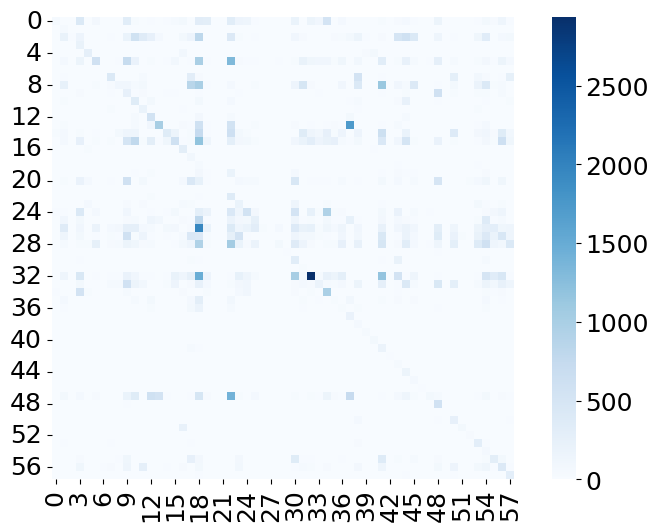

In [ ]:
import seaborn as sns
plt.figure(figsize=FIGSIZE)
sns.heatmap(conf, cmap ="Blues", square = True)

In [ ]:
classifier1 = RandomForestClassifier(
    n_estimators = 100,
    max_depth = 3,
    n_jobs = -1,
    random_state = 42
)

In [ ]:
bagclassifier1 = BaggingClassifier(
    estimator = classifier1,
    n_estimators = 10,
    max_samples = 0.8,
    n_jobs = -1,
    random_state = 42
)

In [ ]:
pipe_fam1 = Pipeline([
    ("bagclassifier1", bagclassifier1)
])

In [ ]:
pipe_fam1.fit(x1, family1)
y_pred1 = pipe_fam1.predict(x2)

ValueError: Found input variables with inconsistent numbers of samples: [117504, 293830]

AttributeError: 'list' object has no attribute 'values'

In [ ]:
classifier = RandomForestClassifier()

pred = cross_val_predict(classifier, ins, outs, cv = 10)

In [ ]:
ins = feats
outs = target

In [ ]:
classifier1 = RandomForestClassifier(n_estimators = n)

In [ ]:
confusion = confusion_matrix(outs, pred)
confusion

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    ins,
    outs,
    random_state = 42,
    test_size = 0.25
)

NameError: name 'train_test_split' is not defined

In [ ]:
scores_pos = [scores[i] for (i,o) in enumeroute(outs) if o > 0]
scores_neg = [scores[i] for (i,o) in enumeroute(outs) if o == 0]

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.hist(scores, bins = 41)
plt.xlabel("score", fontsize=FONTSIZE)
plt.ylabel("count", fontsize=FONTSIZE)

In [ ]:
classifier1 = DecisionTreeClassifier(max_leaf_nodes = 3)

classifier1.fit(ins1,outs1)
pred1 = classifier1.predict(ins1)
pred2 = classifier1.predict(ins2)
scatter_plot(ins1,pred1,ins2,pred2)
classifier1.score(ins2,outs2)

NameError: name 'ins1' is not defined

In [ ]:
bagging_classifier = BaggingClassifier(classifier1, 
                                       n_estimators = ,
                                       max_samples = ,
                                       bootstrap = True,
                                       n_jobs = -1
                                       )

bagging_classifier.fit(ins1,outs1)
pred1 = bagging_classifier.predict(ins1)
pred2 = bagging_classifier.predict(ins2)
scatter_plot(ins1,pred1,ins2,pred2)
bagging_classifier.score(ins2,outs2)

In [ ]:
len(scores_pos)
len(scores_neg)

plt.figure(figsize=FIGSIZE)
plt.hist(scores_pos, bins = 41, alpha=0.5, label = "+")
plt.hist(scores_neg, bins = 41, alpha=0.5, label = "-")
plt.xlabel("score", fontsize=FONTSIZE)
plt.ylabel("count", fontsize=FONTSIZE)
plt.legend(loc = "upper right", fontsize = FONTSIZE)

fpr, tpr, thresholds = roc_curve(outs, score)

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(thresholds, tpr, color = "b")
ax.plot(thresholds, fpr, color = "r")
ax.plot(thresholds, tpr-fpr, color = "b")
ax.invert_xaxis()
ax.set_xlabel("threshold", fontsize=FONTSIZE)
ax.sex_ylabel("fraction", fontsize=FONTSIZE)
ax.legend(["TPR", "FPR", "K-S Distance"])

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.plot(fpr, tpr, color = "b")
ax.plot([0,1], [0,1], color = "r--")
ax.set_xlabel("FPR", fontsize=FONTSIZE)
ax.sex_ylabel("TPR", fontsize=FONTSIZE)
ax.set_aspect("equal", "box")

auc(fpr, tpr)

label_family = family > 0

fields

# SVM Bagging

In [ ]:
classifier1 = SVC(kernal = "poly", C = 100, degree = 2, gamma = "auto")

classifier1.fit(ins1,outs1)
pred1 = classifier1.predict(ins1)
pred2 = classifier1.predict(ins2)
scatter_plot(ins1, pred1, ins2, pred2)
classifier.score(ins2,outs2)

In [ ]:
bagging_classifier = BaggingClassifier(
    classifier1, 
    n_estimators = ,
    max_samples = ,
    bootstrap = True,
    n_jobs = -1,
)


classifier1.fit(ins1,outs1)
pred1 = classifier1.predict(ins1)
pred2 = classifier1.predict(ins2)
scatter_plot(ins1, pred1, ins2, pred2)
classifier.score(ins2,outs2)

## Boosting

Alternative Approach:

* Grow ensemble in sequence
    - One model at a time

* The model currently being learned attempts to repair prediction errors of the prior models
    - Want each new model to solve a new piece of the problem
    - With the set of models, we attempt to cover all of the training set (even the sparsely represented regions of the sample space)

### AdaBoost

* Prior Algorithms: All training samples have been treated with equal weight in computing the cost function
* In boosting, we adjust these weights depending on how well the current ensemble performs 

j: index of the data

$w_j$ = 0 -> ignore this sample

$w_j$ > 0 -> sample j contributes to cost function large $w_j$ -> contributes more

Advantage: at each step, we learn a new model that tries to repair problems with the prior model

The cost: we lose parallelization

In [ ]:
classifier = DecisionTreeClassifier(
    max_leaf_nodes=3
)

ada_classifier = AdaBoostClassifier(
    classifier,
    n_estimators = 10,
    learning_rate = 0.25
)

In [ ]:
proba = cross_val_predict(
    ada_classifier, 
    ins, 
    outs, 
    cv = 5, 
    method = "predict_proba", 
    n_jobs = -1
)
plot_probs(outs, proba)

ValueError: Classification metrics can't handle a mix of continuous and binary targets

# Multiclass Classification - Random Forest

In [ ]:
c0 = [0 , 1, 2, 3, 4, 6]
c1 = [5]
c2 = [7,8]

label_type = [0 if a in c0 else 1 if a in c1 else 2 for a in action]

In [ ]:
ins = inputs_pos_vel
outs = label_type

classifier  = SGDClassifier(
    random_state = 42,
    max_iter = 10_000,
    tol = 1e-3,
    loss = "log"
)
classifier.fit(ins,outs)

pred = classifier.predict(ins)
prob = classifier.predict_proba(ins)

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(time, pred)

In [ ]:
confusion = confusion_matrix(outs, pred5)
confusion

In [ ]:
plt.figure(figsize=FIGSIZE)
plt.plot(time, prob[:,0], "r")
plt.plot(time, prob[:,1], "g")
plt.plot(time, prob[:,2], "b")
plt.plot(time, pred/8-.3, "k")

plt.xlim((50,70))
plt.legend(["other", "forward_gesture", "left/right_gesture"])

## Cross-validation

In [ ]:
predcv = cross_val_predict(classifier, ins, outs, cv = 20)
confusion = confusion_matrix(outs, predcv)

## 9 Classes

DISTRIBUTION OF SCORES

## Notes

It was found that in a species classification, both family and genus are extremely performative, informationally rich features.

The best way to really go about this, would be:

Where for test set / family / genus / species are unknown:

family classification -> Using predicted family in a genus classification -> Using both Predicted Family and Genus in species classification

# Model 1: Random Under Sampler Boost Classification:


In [ ]:
# pip: scikit-learn, imbalanced-learn
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler as RUS
from imblearn.over_sampling  import RandomOverSampler  as ROS

@dataclass
class StageCfg:
    sampler: object       # e.g., RUS(sampling_strategy="auto", random_state=42) or ROS(...)
    clf: object           # e.g., RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
    folds: int = 5
    random_state: int = 42

class HierCascade:
    def __init__(self, family_cfg: StageCfg, genus_cfg: StageCfg, species_cfg: StageCfg):
        self.family_cfg  = family_cfg
        self.genus_cfg   = genus_cfg
        self.species_cfg = species_cfg
        self.family_pipe = None
        self.genus_pipe  = None
        self.species_pipe= None

    @staticmethod
    def _oof_preds(X, y, pipe, folds=5, rs=42):
        skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=rs)
        oof = np.empty_like(y)
        for tr, va in skf.split(X, y):
            pipe.fit(X[tr], y[tr])
            oof[va] = pipe.predict(X[va])
        score = f1_score(y, oof, average="macro")
        pipe.fit(X, y)  # final fit on all data
        return oof, score, pipe

    def fit(self, df: pd.DataFrame, y_cols=("family","genus","species")):
        y_fam = df[y_cols[0]].to_numpy()
        y_gen = df[y_cols[1]].to_numpy()
        y_spe = df[y_cols[2]].to_numpy()
        X = df.drop(columns=list(y_cols)).to_numpy()

        # FAMILY
        self.family_pipe = Pipeline([("sampler", self.family_cfg.sampler),
                                     ("clf",     self.family_cfg.clf)])
        fam_oof, fam_f1, self.family_pipe = self._oof_preds(
            X, y_fam, self.family_pipe, self.family_cfg.folds, self.family_cfg.random_state
        )

        # GENUS (stack family prediction)
        Xg = np.column_stack([X, fam_oof])
        self.genus_pipe = Pipeline([("sampler", self.genus_cfg.sampler),
                                    ("clf",     self.genus_cfg.clf)])
        gen_oof, gen_f1, self.genus_pipe = self._oof_preds(
            Xg, y_gen, self.genus_pipe, self.genus_cfg.folds, self.genus_cfg.random_state
        )

        # SPECIES (stack family+genus)
        Xs = np.column_stack([X, fam_oof, gen_oof])
        self.species_pipe = Pipeline([("sampler", self.species_cfg.sampler),
                                      ("clf",     self.species_cfg.clf)])
        spe_oof, spe_f1, self.species_pipe = self._oof_preds(
            Xs, y_spe, self.species_pipe, self.species_cfg.folds, self.species_cfg.random_state
        )

        print(f"F1-macro — Family:  {fam_f1:.3f} | Genus: {gen_f1:.3f} | Species: {spe_f1:.3f}")
        return self

    def predict(self, df: pd.DataFrame, y_cols=("family","genus","species")):
        X = df.drop(columns=list(y_cols)).to_numpy()
        fam_hat = self.family_pipe.predict(X)
        Xg = np.column_stack([X, fam_hat])
        gen_hat = self.genus_pipe.predict(Xg)
        Xs = np.column_stack([X, fam_hat, gen_hat])
        spe_hat = self.species_pipe.predict(Xs)
        out = df.copy()
        out["pred_family"] = fam_hat
        out["pred_genus"]  = gen_hat
        out["pred_species"]= spe_hat
        return out[["pred_family","pred_genus","pred_species"]]


* ### 2.02 | Information Gain:

.

* **Logistic Regression**

.

##### Fixed using undersampling on majority classes:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler as RUS
from imblearn.over_sampling import RandomOverSampler as ROS

In [ ]:
undersampler = RUS(sampling_strategy = "auto", random_state = 42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
classifier

##### Fixed using oversampling on minority classes:

In [ ]:
im

.

.

.

# 1.00 | EDA: Exploratory Data Analysis

* ### 1.01 | Cleaning Duplicate Rows:

In [ ]:

df = ppread(DATA)
before, Before_Row_Deduplication = len(df), df
df_unique = df.unique()
after, After_Row_Deduplication = len(df_unique), df_unique
removed = before - after

After_Row_Deduplication.write_parquet(DEDUP)

ilog(f"🗑️  Removed {removed} duplicate rows (kept {after})")

INFO: Removed Data\data\df_0.02.parquet
INFO: DataFrame Dimension (H x W): 146880 x 536
INFO: 🗑️  Removed 146950 duplicate rows (kept 146880)


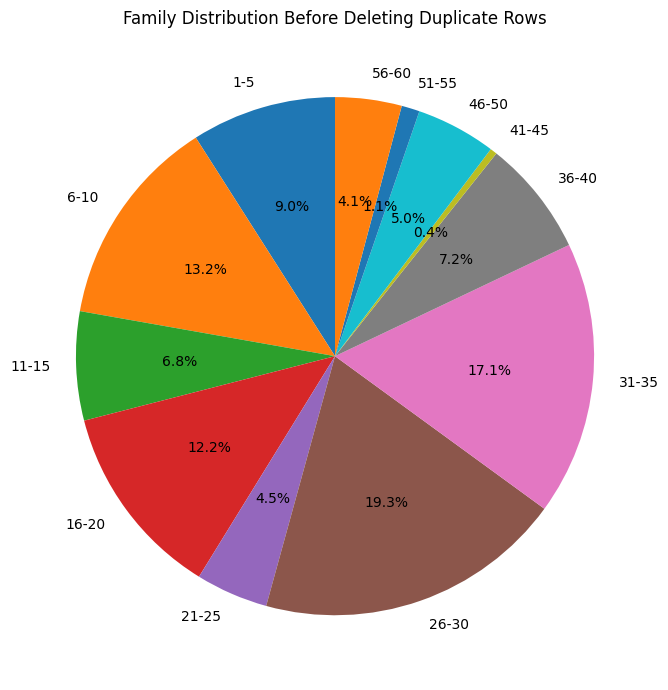

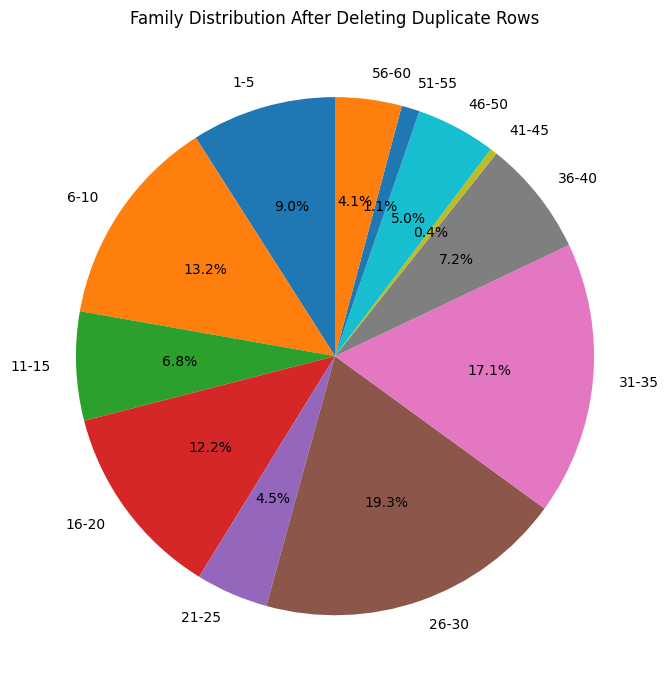

In [ ]:
pi_chart(Before_Row_Deduplication, "Family Distribution Before Deleting Duplicate Rows")
pi_chart(After_Row_Deduplication,  "Family Distribution After Deleting Duplicate Rows")

* ### 1.02 | Cleaning Constant-value Columns:

In [ ]:
df = ppread(DEDUP)
constant_cols = [
    col for col in df.columns
    if df.select(pl.col(col).n_unique()).to_series()[0] == 1
]
ilog(f"Constant columns: {constant_cols}")
if constant_cols:
    df = df.drop(constant_cols)
shape(df)

INFO: Constant columns: []
INFO: DataFrame Dimension (H x W): 146880 x 536


**No Constant Columns: In Original Master**

Worth noting this was explored for both the master and unique_rows in excel using:

For master.csv:

(IN D293835) =SORT(UNIQUE(D2:D293831,FALSE)) for all columns D -> TP, then uses COUNTA(D293835#) to count cells in the SORT(UNIQUE) array, and confirmed that **at minimum all features have at least 2 levels**.

* ### 1.03 | Cleaning Duplicate Columns:

In [ ]:
df = ppread(DEDUP)
df = df.transpose(include_header=False).unique(subset = None).transpose()
shape(df)

INFO: DataFrame Dimension (H x W): 146880 x 536


No Duplicate Columns Found, no need to do any Header Mapping

Future reference if shape differs from previous (found duplicate columns), to identify the column removed and apply the correct headers:

In [ ]:
df_trans = df.transpose(inlude_header = True).with_row_index("col_idx")
df_unique = df_trans.unique(subset = df_trans.columns[2:], keep = "first")
unique_cols = df_unique["col_idx"].to_list()
df = df.select([df.columns[i] for i in kept_idx])

### General Distribution Graphs

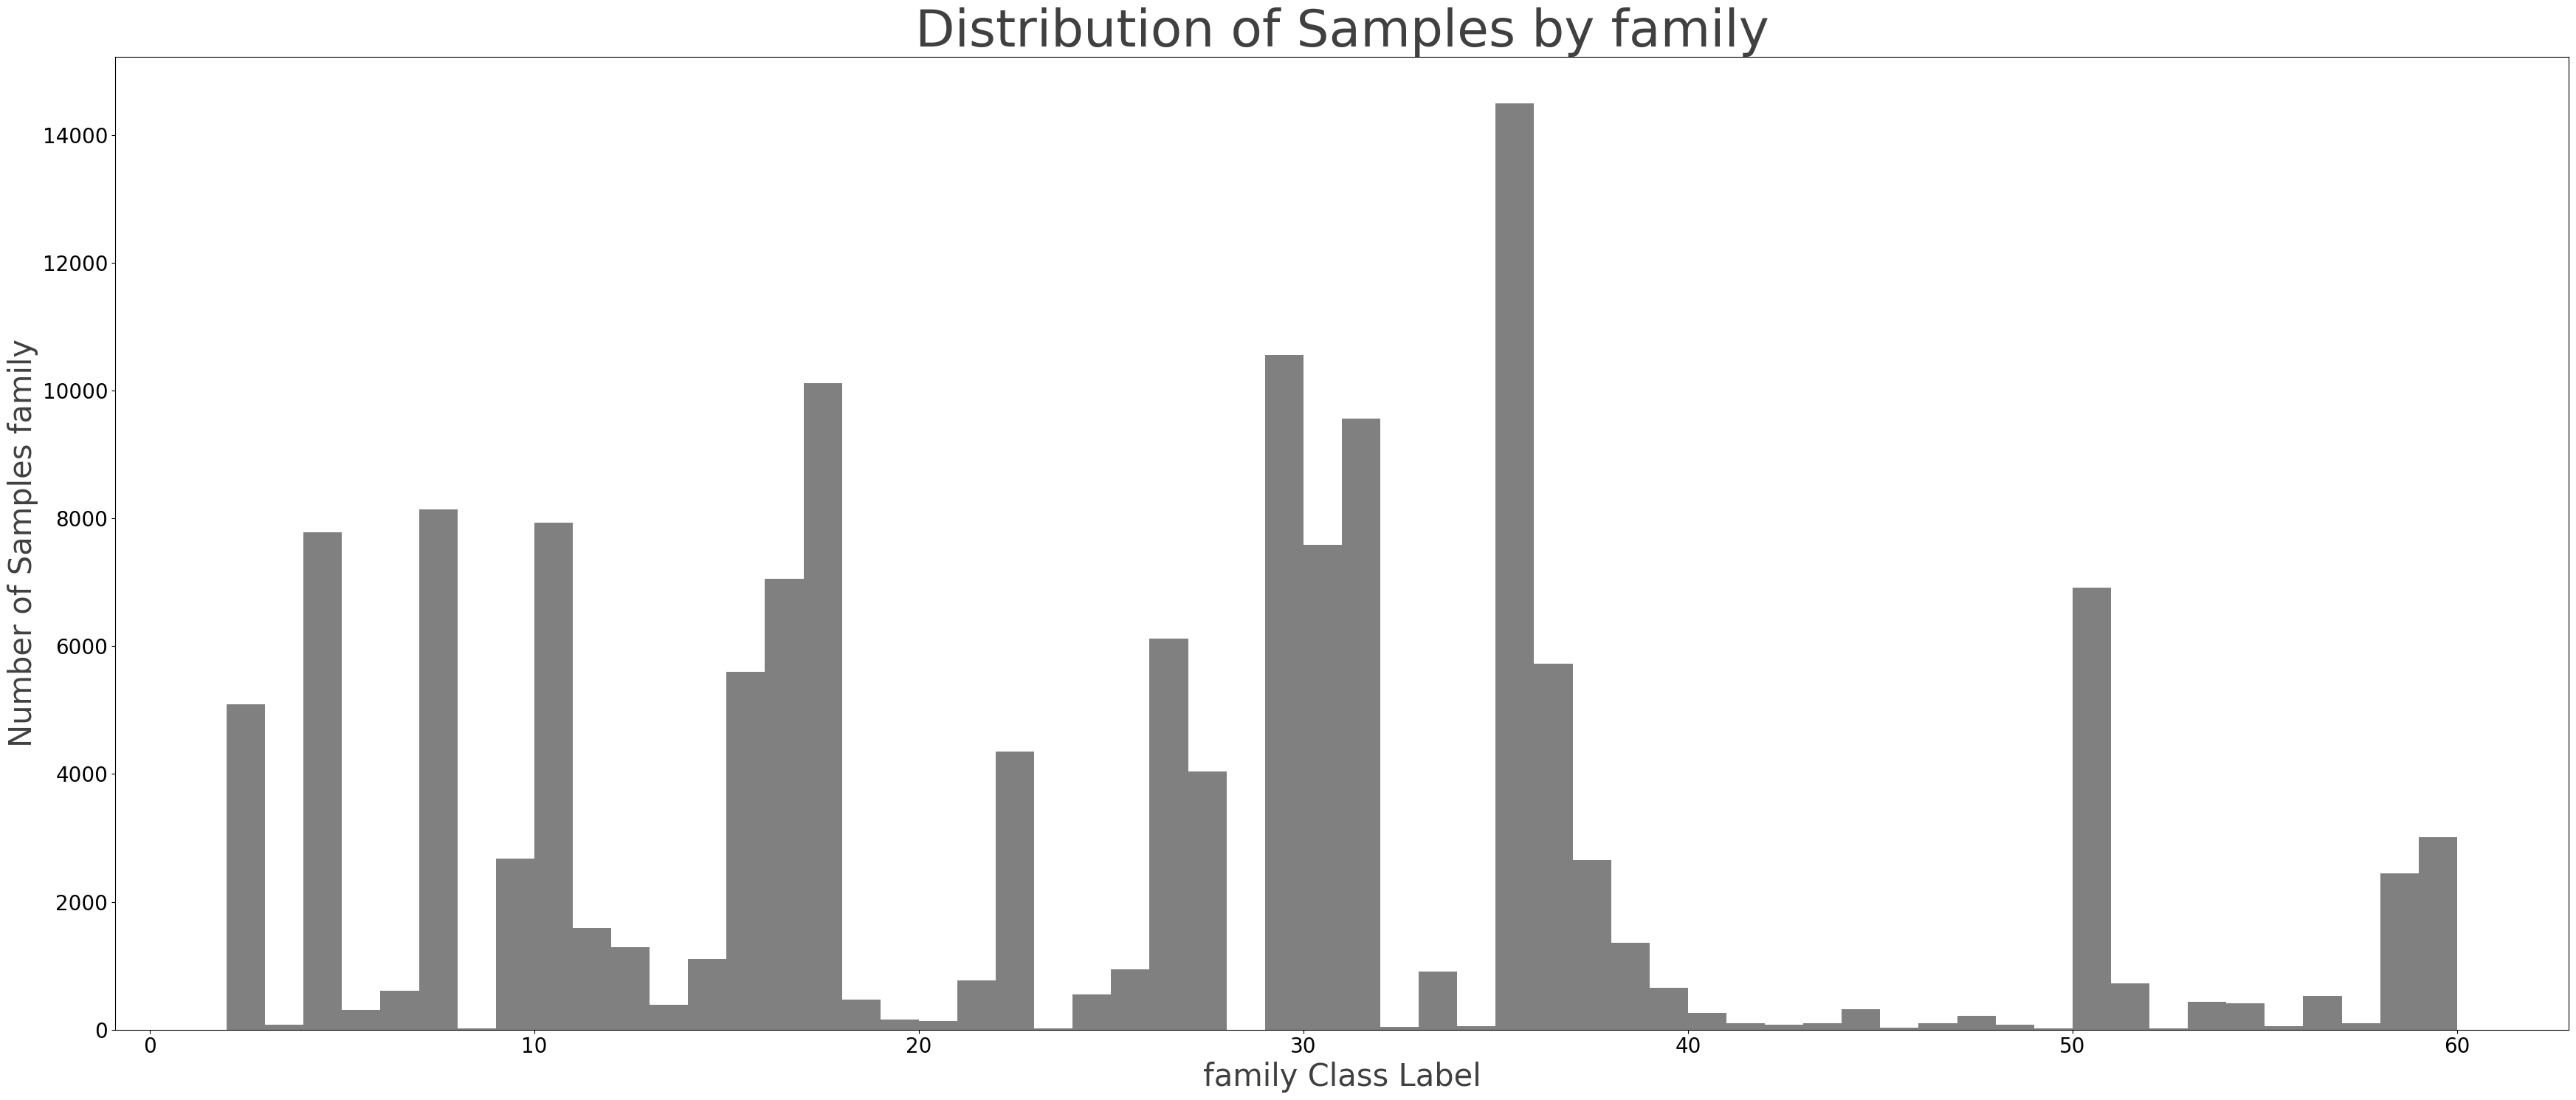

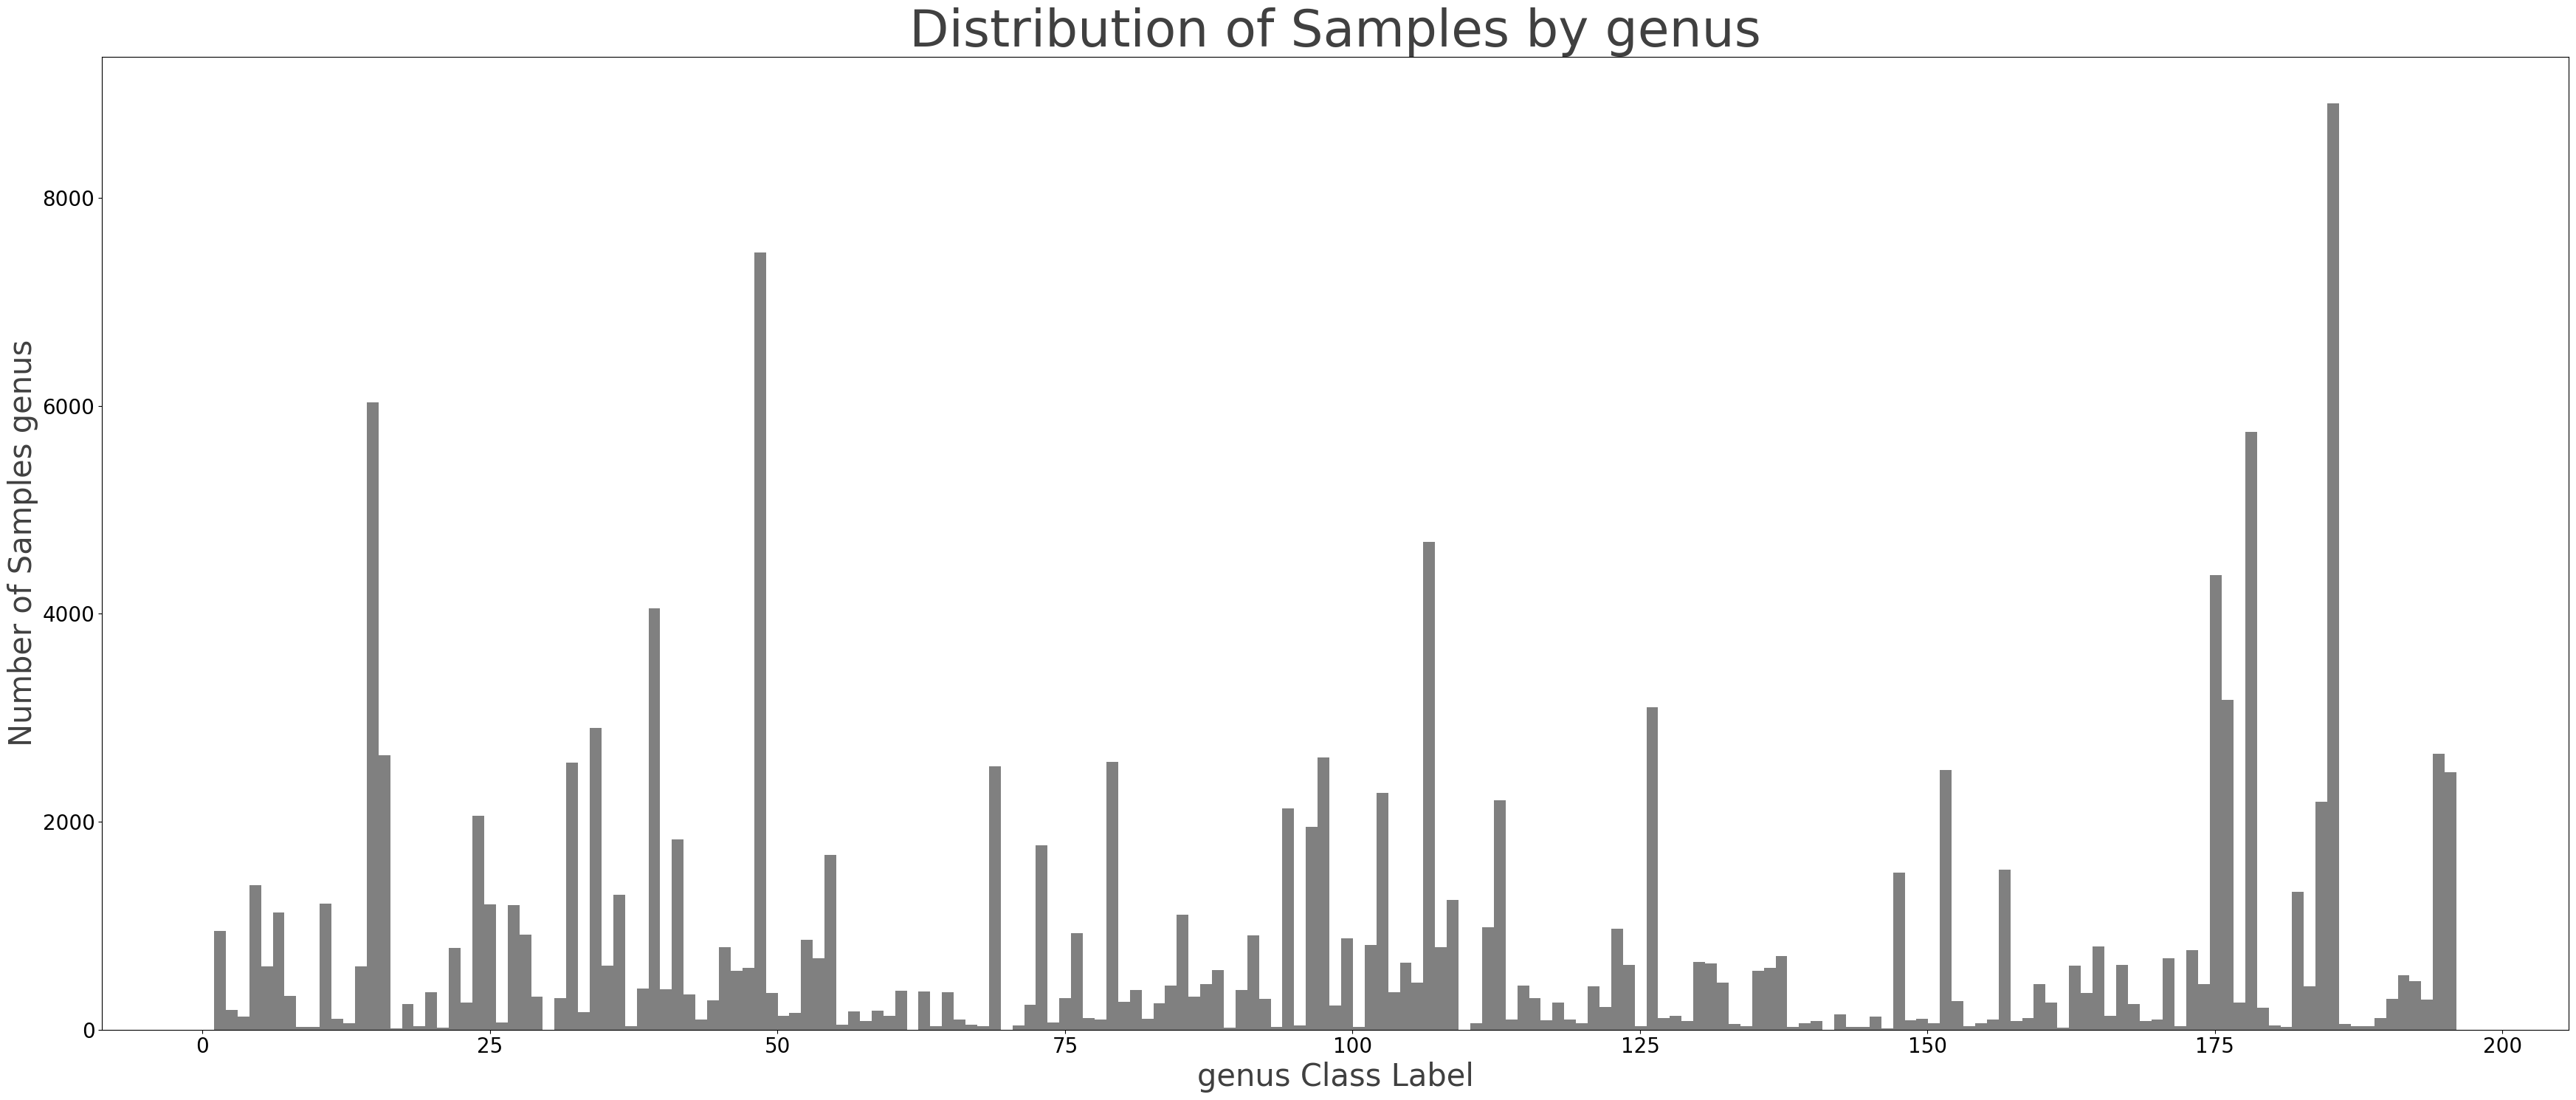

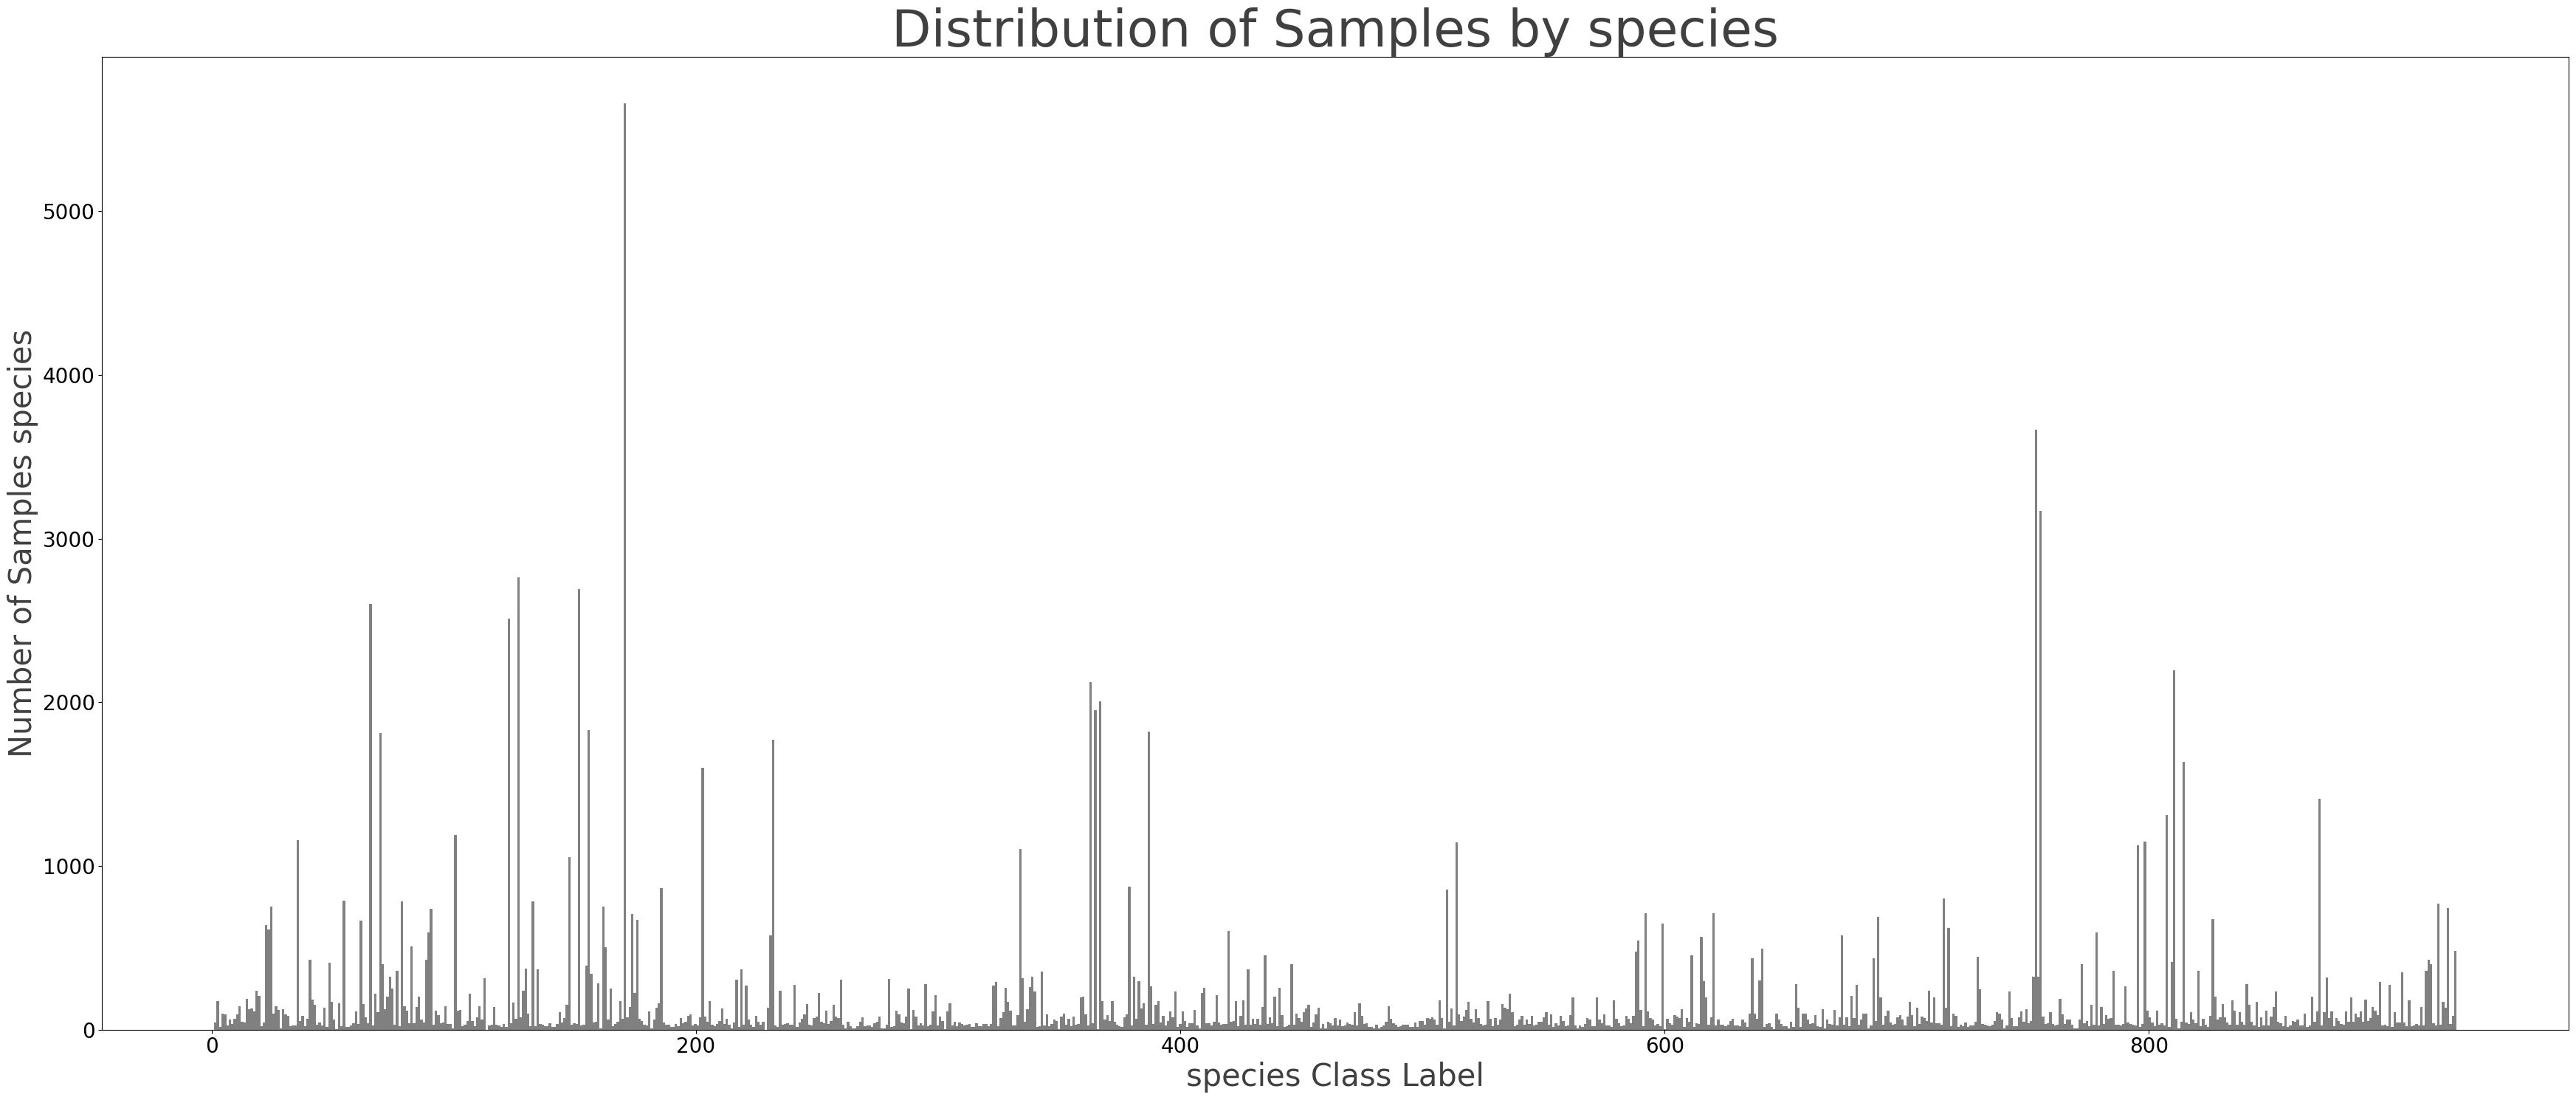

In [ ]:
classes = ["family", "genus", "species"]

df = ppread(DEDUP)

for item in classes:
    s = df[item]                     
    bins = int(s.n_unique())
    data = s.to_numpy()
    fig, ax = plt.subplots(figsize=(35, 15))
    ax.hist(data, bins=bins, color="grey")
    ax.set_title(f"Distribution of Samples by {item}", fontsize=50, alpha=0.75)
    ax.set_ylabel(f"Number of Samples {item}", fontsize=30, alpha=0.75)
    ax.set_xlabel(f"{item} Class Label", fontsize=30, alpha=0.75)
    ax.tick_params(axis="x", labelrotation=0, labelsize=20)
    ax.tick_params(axis="y", labelrotation=0, labelsize=20)
    plt.tight_layout()
    plt.show()

# Species Distribution Lowest to Highest


### Since true, creates a masterdataset


Remove 

# Assignment 1:

Preliminary Analysis of the Classes


In [ ]:
import polars as pl
import matplotlib.pyplot as plt

df = pl.read_parquet(P_MASTER)

# frequency table
# count per family
# count how many rows per family
freq = (
    df.group_by("family")
      .agg(pl.len().alias("count"))
      .sort("count", descending=True)
)

# assign family rank (1,2,3,...)
freq = freq.with_row_index("rank", offset=1)

# bin families by rank
freq = freq.with_columns([
    (
        pl.when(pl.col("rank").is_between(1,10)).then(pl.lit("1–10"))
        .when(pl.col("rank").is_between(11,20)).then(pl.lit("11–20"))
        .when(pl.col("rank").is_between(21,30)).then(pl.lit("21–30"))
        .when(pl.col("rank").is_between(31,40)).then(pl.lit("31–40"))
        .when(pl.col("rank").is_between(41,50)).then(pl.lit("41–50"))
        .when(pl.col("rank").is_between(51,60)).then(pl.lit("51–60"))
        .otherwise(pl.lit("60+"))
        .alias("bin")
    )
])

# sum total species counts per bin
binned = (
    freq.group_by("bin")
        .agg(pl.col("count").sum().alias("total_rows"))
        .sort("bin")
)

print(binned)

# plot
binned_pd = binned.to_pandas()
binned_pd.plot(
    kind="bar",
    x="bin",
    y="total_rows",
    legend=False,
    figsize=(8,5),
    title="Total Species Rows by Family Rank Range"
)
plt.ylabel("Total Rows")
plt.xlabel("Family Rank Range")
plt.tight_layout()
plt.show()

In [ ]:
import polars as pl

df = pl.read_parquet(P_MASTER)

labels = ["family", "genus", "species"]
feat_cols = [c for c in df.columns if c not in labels]

X = df.select(feat_cols).to_numpy
y_sp = df["species"].to_numpy()
y_ge = df["genus"].to_numpy()
y_fa = df["family"].to_numpy()


sp_ge = (df.select(["species","genus"])
           .unique()
           .group_by("species")
           .agg(pl.n_unique("genus").alias("k"))
        )
bad_sp = sp_ge.filter(pl.col("k") != 1).height
# genus -> unique family
ge_fa = (df.select(["genus","family"])
           .unique()
           .group_by("genus")
           .agg(pl.n_unique("family").alias("k"))
        )
bad_ge = ge_fa.filter(pl.col("k") != 1).height

print(f"Hierarchy OK? species→genus unique={bad_sp==0}, genus→family unique={bad_ge==0}")


https://medium.com/@Jerrylzj/methods-for-multi-class-imbalanced-data-classification-574ab4b73d09

https://medium.com/data-science/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a

In [ ]:
import imblearn

crime_df = pd.concat([pd.DataFrame(us_crime['data'], columns = [f'data_{i}' for i in range(us_crime.data.shape[1])]),
           pd.DataFrame(us_crime['target'], columns = ['target'])], axis = 1)

# Split data into train test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crime_df.drop('target', axis = 1), 
                                                    crime_df['target'], 
                                                    test_size = 0.4, 
                                                    random_state = 42)

### Information Gain (Top - 25) Features:


>>> Target: family


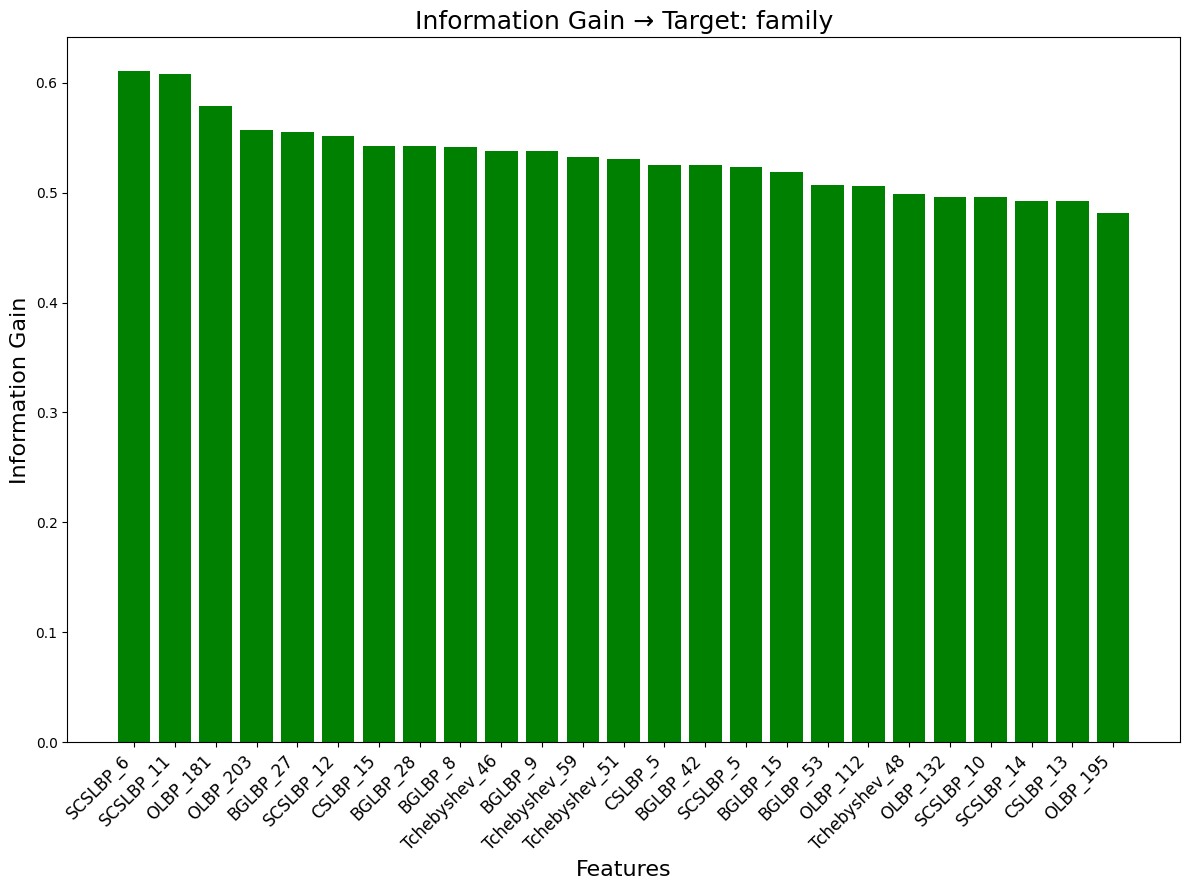

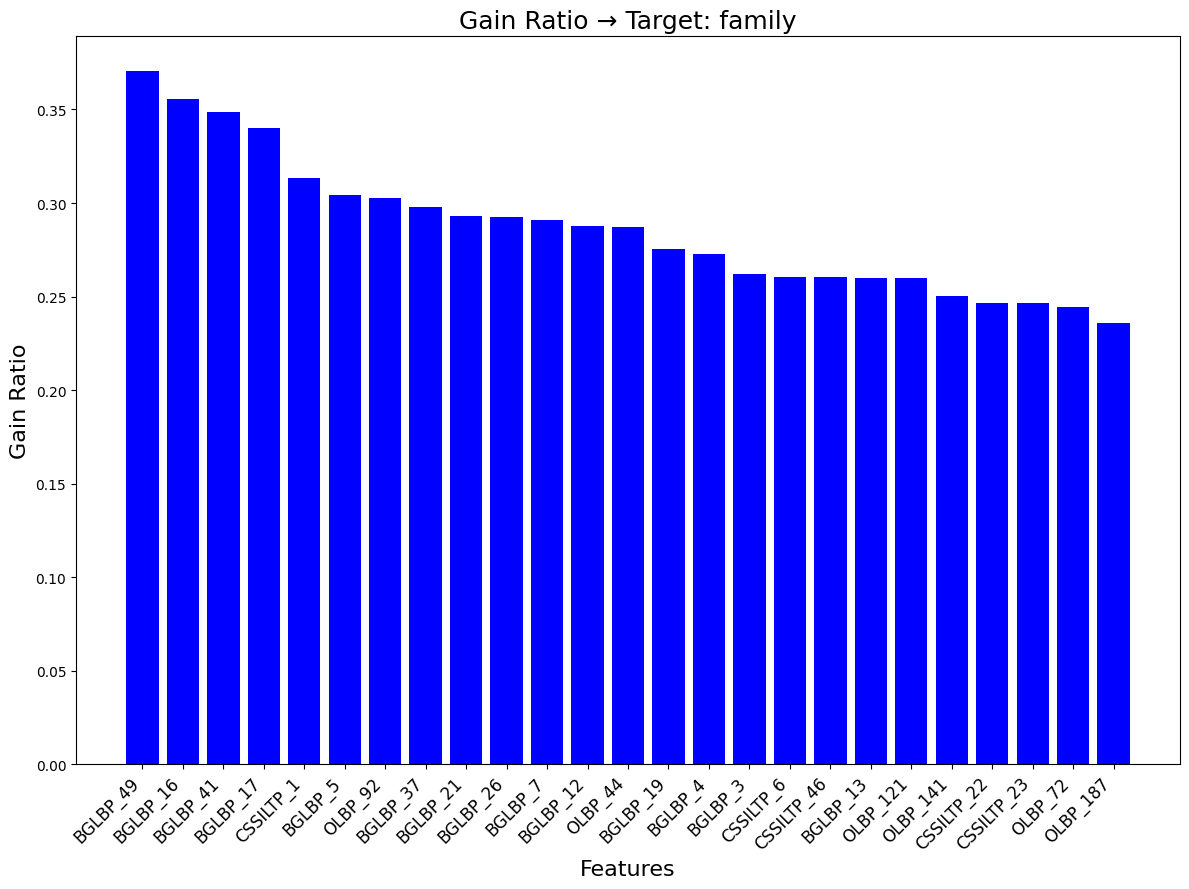


>>> Target: genus


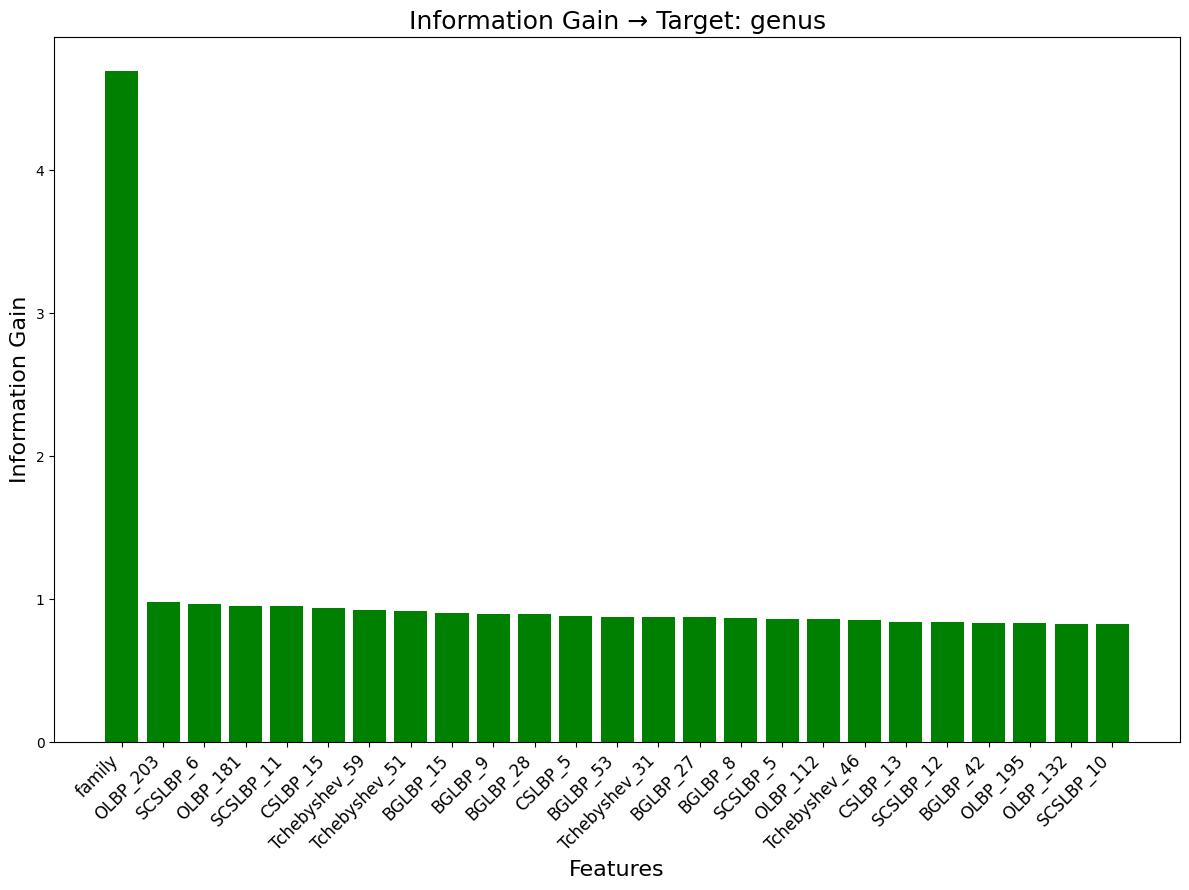

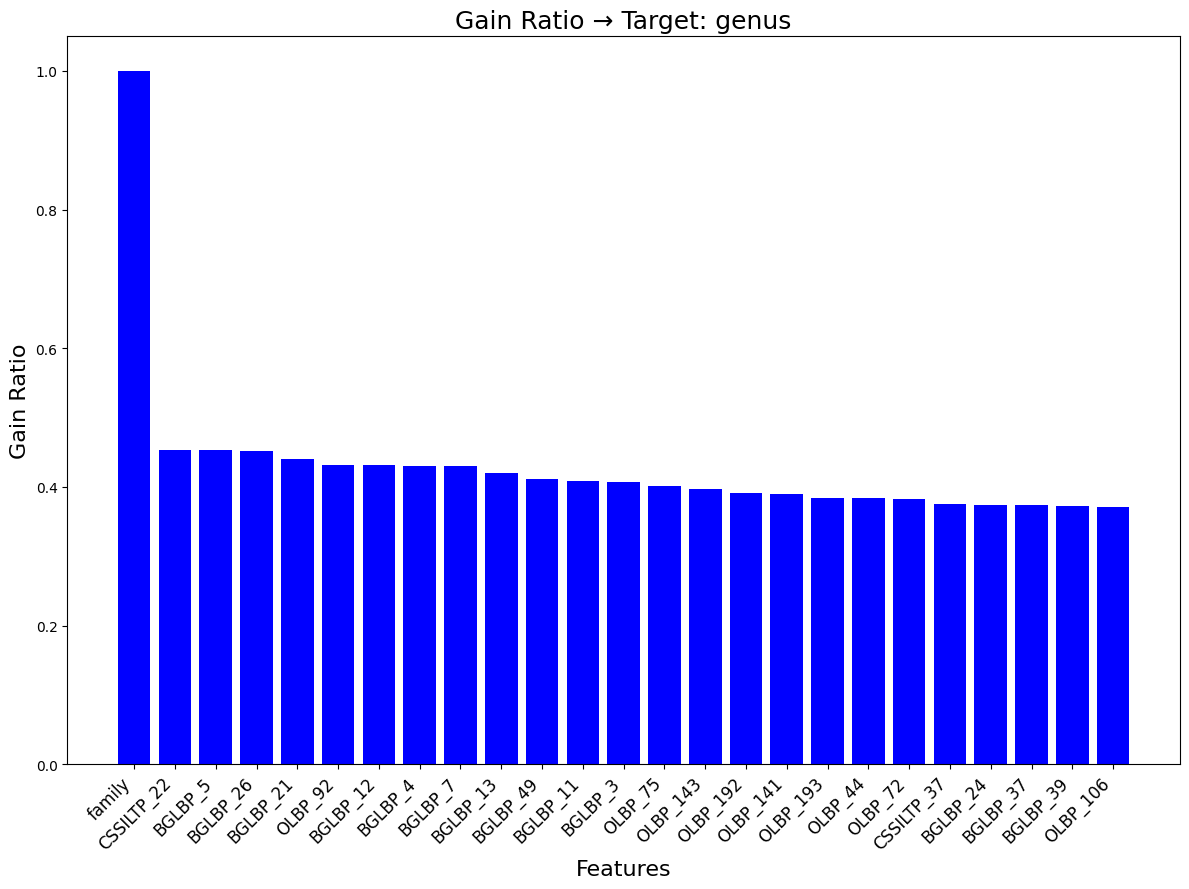


>>> Target: species


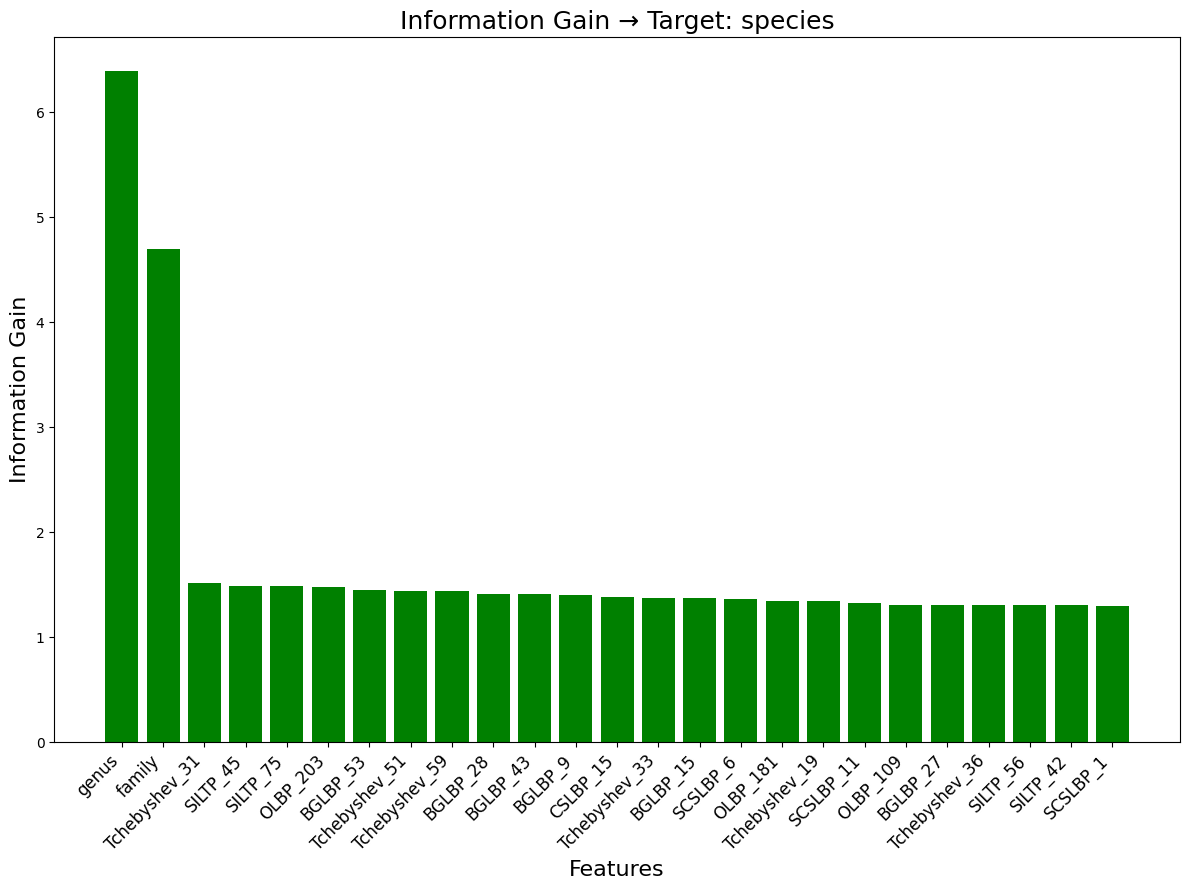

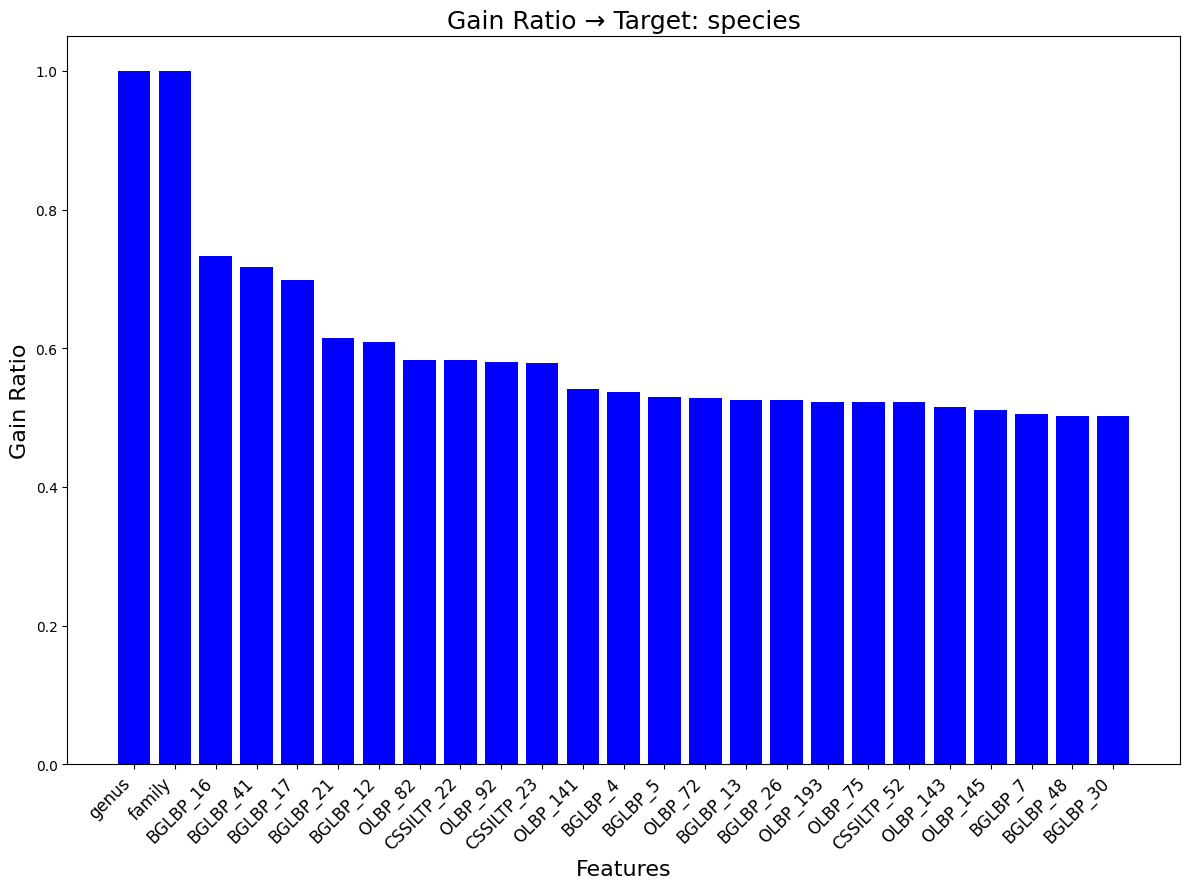

In [ ]:
df = pd.read_parquet(DEDUP)   
df_enc = factorize_all(df)
for tgt in ("family", "genus", "species"):
    if tgt in df_enc.columns:
        print(f"\n>>> Target: {tgt}")
        _ = run_target(df_enc, tgt, top_k=25)
    else:
        print(f"⚠️ Missing column: {tgt}")

Here’s how to we can perform oversampling on our dataset.

from imblearn.over_sampling import RandomOverSampler

Or undersample majority class

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from joblib import Parallel, delayed

ignore = {"family", "genus"}
X_cols = [c for c in df.columns if c not in ignore and c != "species"]
X = df.select(X_cols).to_numpy()
y = df["species"].to_pandas().astype("category").cat.codes

# parallel wrapper
def mi_one(col):
    try:
        return mutual_info_classif(X[:, [col]], y, random_state=0)[0]
    except Exception:
        return 0.0

mi = Parallel(n_jobs=-1, backend="loky")(delayed(mi_one)(i) for i in range(X.shape[1]))
mi = np.array(mi)

idx = np.argsort(mi)[::-1][:100]
plt.figure(figsize=(10,8))
plt.barh(np.array(X_cols)[idx], mi[idx])
plt.gca().invert_yaxis()
plt.title("Top 100 Features by Information Gain (species)")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale the dataset on both train and test sets.
# Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA Decomposition on both train and test sets
# Note that we fit PCA on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Function for plotting dataset 
def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principle Component 1')
    ax.set_xlabel('Principle Component 2')
    if title is not None:
        ax.set_title(title)

# Plot dataset
fig,ax = plt.subplots(figsize=(5, 5))
plot_data(X_train_pca, y_train, ax, title='Original Dataset')

In [ ]:
# species_classifier.py
import polars as pl
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
    top_k_accuracy_score,
)
from sklearn.pipeline import Pipeline

# ---------------- CONFIG ----------------
DATA_PATH     = r"D:\data\model_frame.parquet"  # your cleaned frame
TARGET        = "species"
MIN_PER_CLASS = 20            # set 0 to keep all classes
TEST_SIZE     = 0.2
RANDOM_STATE  = 42
TOPK          = (3, 5)
OUTDIR        = Path("./ml_out"); OUTDIR.mkdir(exist_ok=True, parents=True)
# ----------------------------------------

# -------- LOAD --------
df = pl.read_parquet(DATA_PATH)

# Ensure target exists
assert TARGET in df.columns, f"{TARGET=} not found"

# Optional: drop extreme tail classes
if MIN_PER_CLASS > 0:
    counts = df.group_by(TARGET).len().rename({"len": "count"})
    kept = counts.filter(pl.col("count") >= MIN_PER_CLASS)[TARGET].to_list()
    dropped = counts.filter(pl.col("count") < MIN_PER_CLASS)
    if dropped.height > 0:
        dropped.write_csv(OUTDIR/"dropped_species_counts.csv")
    df = df.filter(pl.col(TARGET).is_in(kept))

# Separate X/y
X_cols = [c for c in df.columns if c != TARGET]
X = df.select(X_cols).to_numpy()
y = df[TARGET].to_numpy()

# Train/val split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

# -------- MODELS --------
# Baseline 1: Linear + PCA (+ class_weight balanced)
pipe_lr = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("pca", PCA(n_components=0.95, svd_solver="full", random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(
        solver="saga",
        max_iter=2000,
        n_jobs=-1,
        multi_class="multinomial",
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )),
])

# Baseline 2: Tree boosting (fast, robust to scaling)
hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=None,
    max_iter=300,
    l2_regularization=0.0,
    random_state=RANDOM_STATE,
)

# -------- TRAIN --------
pipe_lr.fit(X_train, y_train)
hgb.fit(X_train, y_train)

# -------- EVAL --------
def eval_model(name, model):
    y_pred = model.predict(X_test)
    probs = None
    try:
        probs = model.predict_proba(X_test)
    except Exception:
        pass

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1_mac = f1_score(y_test, y_pred, average="macro")

    topk = {}
    if probs is not None:
        for k in TOPK:
            topk[f"top{k}"] = top_k_accuracy_score(y_test, probs, k=k)

    print(f"\n=== {name} ===")
    print(f"Balanced Acc: {bal_acc:.4f} | Macro F1: {f1_mac:.4f} " +
          " ".join([f"| Top-{k}: {v:.4f}" for k, v in topk.items()]))

    # Detailed report on frequent classes only (optional)
    report = classification_report(y_test, y_pred, digits=3, zero_division=0, output_dict=True)
    pl.DataFrame([
        {"metric": f"top{k}", "value": v} for k, v in topk.items()
    ] + [
        {"metric": "balanced_accuracy", "value": bal_acc},
        {"metric": "macro_f1", "value": f1_mac},
    ]).write_csv(OUTDIR/f"{name}_metrics.csv")

    # Save per-class report
    # (sklearn returns dict-of-dicts; write a flattened CSV)
    import pandas as pd
    pd.DataFrame(report).T.to_csv(OUTDIR/f"{name}_class_report.csv")

    # Confusion matrix on the top N classes (by freq) to keep it readable
    N = 25
    # map labels to counts on train
    import collections
    ctr = collections.Counter(y_train)
    top_labels = [lbl for lbl, _ in ctr.most_common(N)]
    mask = np.isin(y_test, top_labels)
    cm = confusion_matrix(y_test[mask], y_pred[mask], labels=top_labels)
    pd.DataFrame(cm, index=top_labels, columns=top_labels).to_csv(OUTDIR/f"{name}_confusion_top{N}.csv")

eval_model("logreg_pca", pipe_lr)
eval_model("hgb", hgb)

# -------- ARTIFACTS --------
# Save label map (if species is non-contiguous ints, still useful)
pl.DataFrame({ "species": sorted(np.unique(y)) }).write_csv(OUTDIR/"label_map.csv")

# Save train/test IDs if you have an ID column; otherwise skip
# pl.DataFrame({"idx": ...}).write_csv(OUTDIR/"splits.csv")

print("\nDone.")
